In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import lzma, pickle
import scipy

load_dir = '../data_frames/'
save_dir = "./figures/plots/"
save_fig = 0 #Change to 1 when you want to save figures
fig_ext = '.pdf'

# Analysis at convergence, fixing ($d$, $\rho$, $\lambda$) and varying $\delta$

---

In [2]:
graph=r"rrg"
d=3
N=10000
init=r"rnd"

g_s = r"graph_type"
d_s = r"$d$"
N_s = r"$N$"
i_s = r"init"

r_s = r"$\rho$"
l_s = r"$\lambda$"
del_s = r"$\delta$"
mo0t_s = r"$\widetilde{MO}_{t=0}$"
Rmse_s = r"$R_{MSE}$"
max_iter=20000

In [3]:
def load_df(name_file):
    file_name = name_file+".xz"
    with lzma.open(load_dir + file_name, "rb") as f:
        data_frame = pickle.load(f)

    mo0t_s = r"$\widetilde{MO}_{t=0}$"
    Rmse_s = r"$R_{MSE}$"
    data_frame = data_frame[(data_frame["o_type"]=="rho") & (data_frame["s_type"]=="delta")]
    data_frame[r_s] = data_frame["M"]
    data_frame["conv"] = data_frame["iteration"] < max_iter
    data_frame[del_s] = data_frame["S"]
    data_frame["error"] = [x.item() for x in data_frame["error"]]
    data_frame["logL"] = [x.item() for x in data_frame["logL"]]
    df_1000_s = data_frame[data_frame["S"]<0.005]
    df_1000_l = data_frame[(data_frame["S"]>=0.005) & (data_frame["S"]<0.09)]
    return data_frame, df_1000_s, df_1000_l

def plot_df(data_frame):
    sns.set_theme(style="whitegrid", font_scale=1.5)
    fig,axs = plt.subplots(3,2, figsize=(20,15))
    N=data_frame.iloc[0]["$N$"]
    plt.suptitle("SNAP, " + l_s + f"= 0.9" + f", N={N}")
    init_s = "rnd"
    log_it="iteration"
    axs[0][0].set(yscale="log")
    sns.lineplot(data=data_frame[(data_frame["init"]==init_s)], x=r"snap_time", hue=del_s, y=log_it, ax=axs[0][0])
    maxx=13
    axs[0][0].plot([0,maxx], [20000,20000])
    sns.scatterplot(data=data_frame[(data_frame["init"]==init_s)], x=r"snap_time", hue=del_s, y=log_it, ax=axs[0][0])
    sns.lineplot(data=data_frame[(data_frame["init"]==init_s)], x=r"snap_time", hue=del_s, y=r"$R_{MSE}$", ax=axs[1][0])
    sns.scatterplot(data=data_frame[(data_frame["init"]==init_s)], x=r"snap_time", hue=del_s, y=r"$R_{MSE}$", ax=axs[1][0])
    sns.lineplot(data=data_frame[(data_frame["init"]==init_s)], x=r"snap_time", hue=del_s, y=r"$\widetilde{MO}_{t=0}$", ax=axs[2][0])
    sns.scatterplot(data=data_frame[(data_frame["init"]==init_s)], x=r"snap_time", hue=del_s, y=r"$\widetilde{MO}_{t=0}$", ax=axs[2][0])

    sns.lineplot(data=data_frame[(data_frame["init"]==init_s)], x=r"snap_time", hue=del_s, y="conv", ax=axs[0][1], estimator="mean", errorbar=None, marker="o", legend=None)
    sns.lineplot(data=data_frame[(data_frame["init"]==init_s)], x=r"snap_time", hue=del_s, y='error', ax=axs[1][1], legend=None)
    sns.scatterplot(data=data_frame[(data_frame["init"]==init_s)], x=r"snap_time", hue=del_s, y='error', ax=axs[1][1], legend=None)
    sns.lineplot(data=data_frame[(data_frame["init"]==init_s)], x=r"snap_time", hue=del_s,y=r'$\delta SE$',  ax=axs[2][1], estimator="mean", marker="o", legend=None)

    #axs[0].set_yscale("log")
    axs[0][0].legend(loc=(1,0.2), fontsize=10)
    axs[1][0].legend(loc=(1,0.), fontsize=10)
    axs[2][0].legend(loc=(1,0.), fontsize=10)

    axs[0][1].set_ylabel("Fraction of converged\n instances")
    axs[1][1].set_ylabel("Average BP error \n(mean)")

    plt.tight_layout()

def miss_values(data_frame, all_ss = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05], all_snap = [0, 1, 2, 3, 4,4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 11, 12, 13], num_seeds=10):
    done_ = np.zeros((len(all_ss), len(all_snap)))
    for row, ss in enumerate(all_ss):
        snaps_to_com = []
        for col, snap_time in enumerate(all_snap):
            df_temp = data_frame[(data_frame['S'] == ss) & (data_frame['snap_time'] == snap_time)]
            done_[row][col] = len(df_temp)
            seeds = df_temp["seed"].unique()
            for ii in range(1,num_seeds+1):
                if ii not in seeds:
                    print(f"delta:{ss}, snap_time:{snap_time}, missing seed:{ii}      ")
            if done_[row][col] == 0: 
                #print(f"delta:{ss}, snap_time:{snap_time}")
                snaps_to_com.append(snap_time)
        if len(snaps_to_com) != 0:
            print(f"missing values delta:{ss}", end=" ")
            for sss in snaps_to_com:
                print(f" {sss}", end="")
        else: 
            print(f"all values delta:{ss}", end=" ")
        print()
    return done_


In [4]:
df_1K, df_1K_s, df_1K_l = load_df("n1K_09")
df_1K = df_1K.drop_duplicates(subset=['snap_time', '$\delta$', 'seed', "init"])
df_1K_s = df_1K_s.drop_duplicates(subset=['snap_time', '$\delta$', 'seed', "init"])
df_1K_l = df_1K_l.drop_duplicates(subset=['snap_time', '$\delta$', 'seed', "init"])


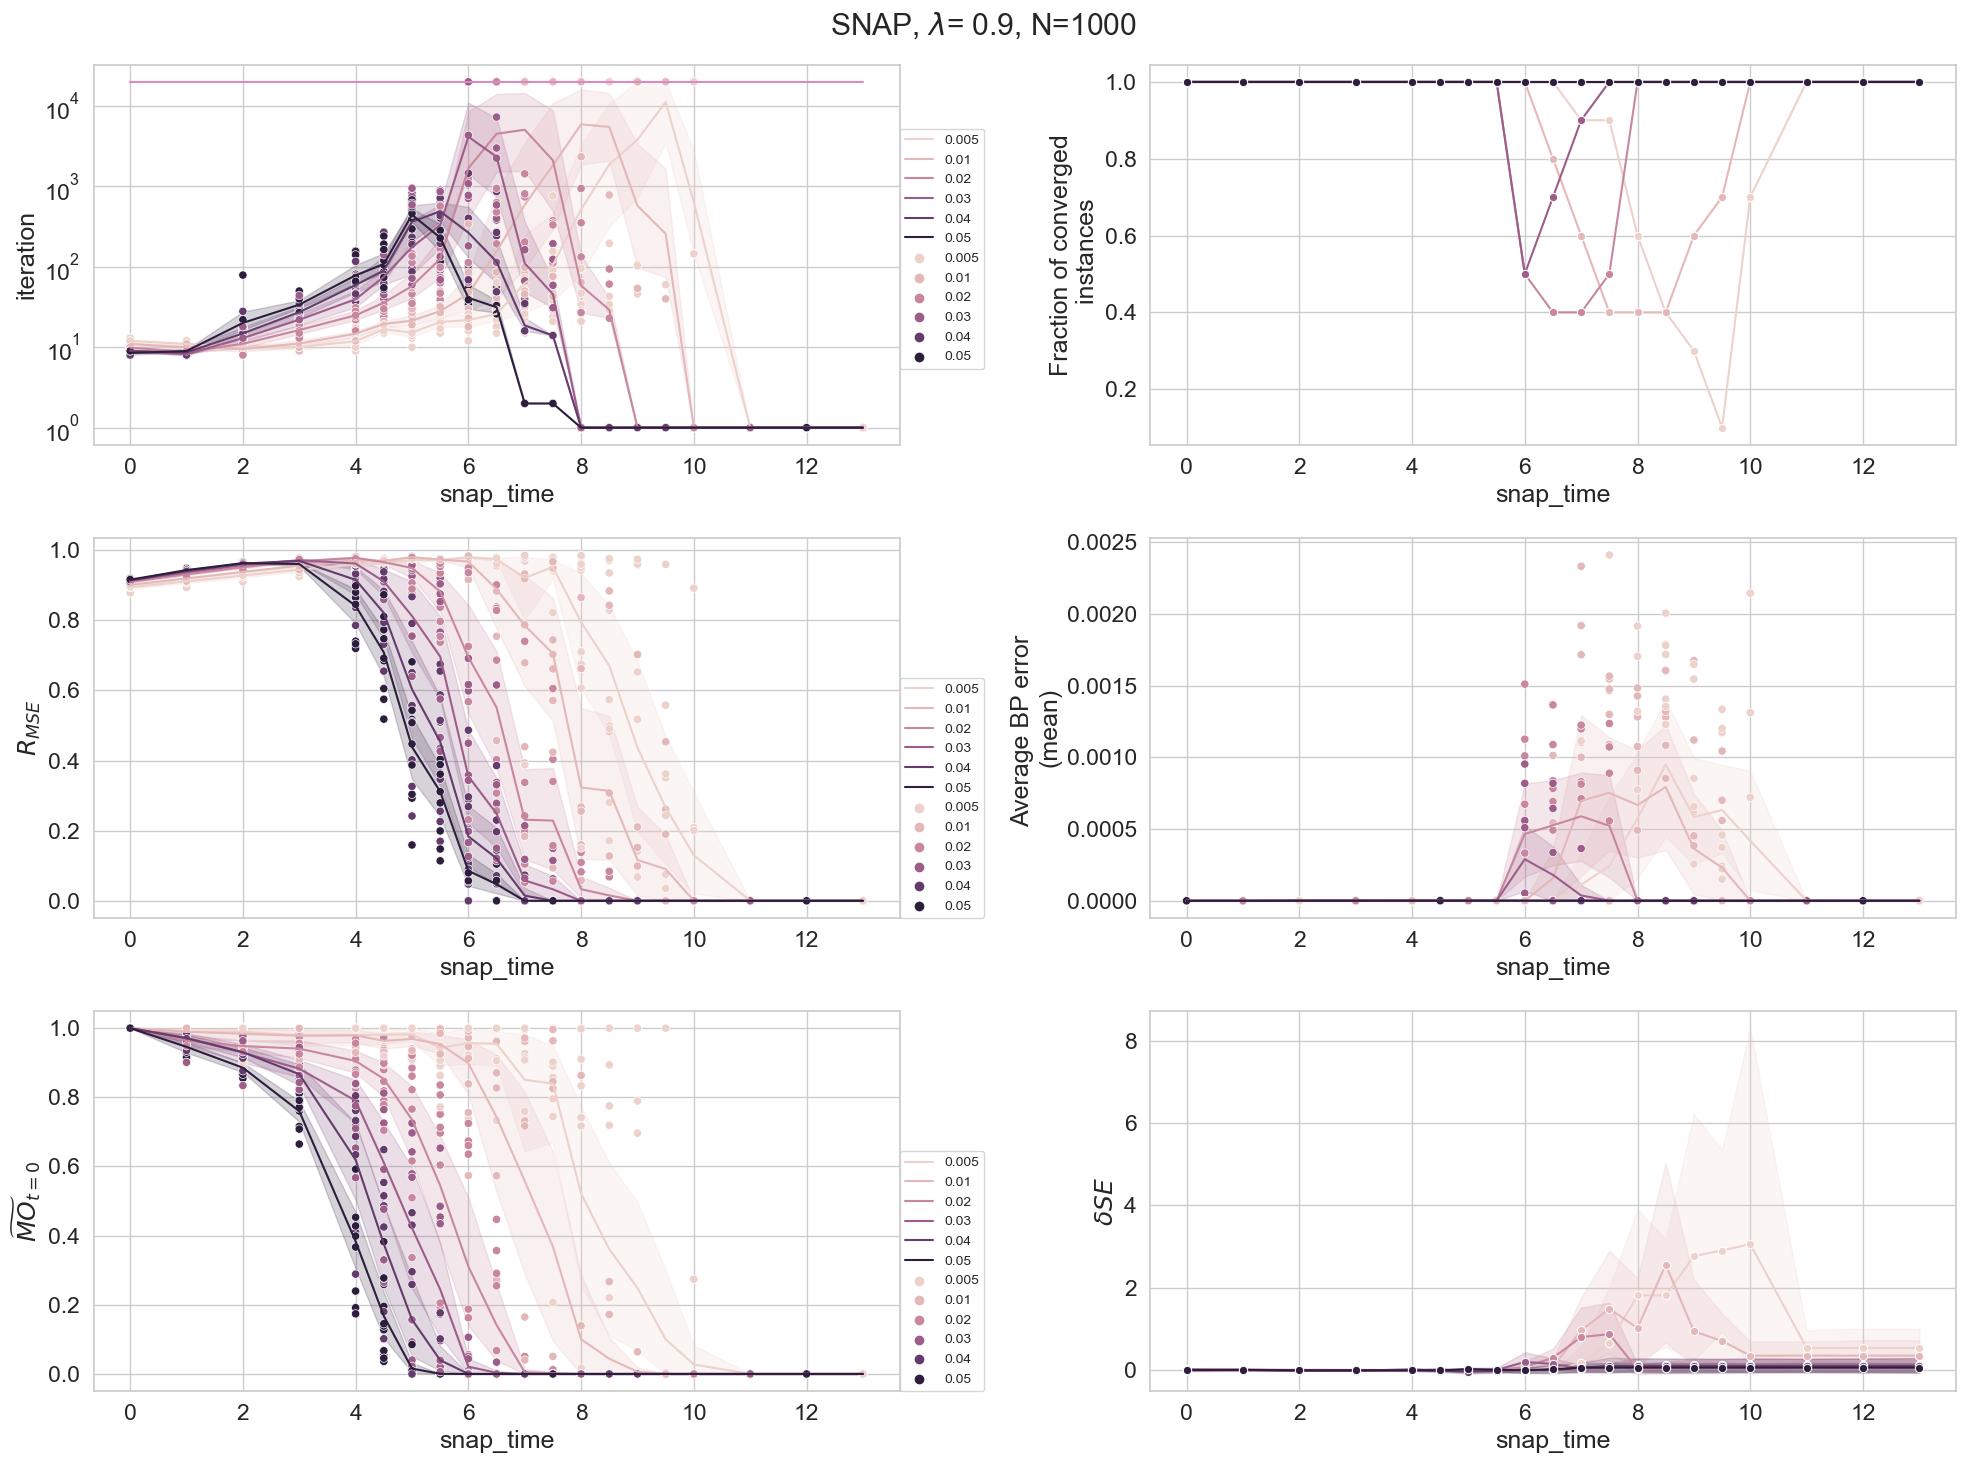

In [5]:
plot_df(df_1K_l)

In [6]:
miss_values(df_1K)

all values delta:0.005 
all values delta:0.01 
all values delta:0.02 
all values delta:0.03 
all values delta:0.04 
all values delta:0.05 


array([[20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
        20., 20., 20., 20., 20., 20., 20.],
       [20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
        20., 20., 20., 20., 20., 20., 20.],
       [20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
        20., 20., 20., 20., 20., 20., 20.],
       [20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
        20., 20., 20., 20., 20., 20., 20.],
       [20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
        20., 20., 20., 20., 20., 20., 20.],
       [20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
        20., 20., 20., 20., 20., 20., 20.]])

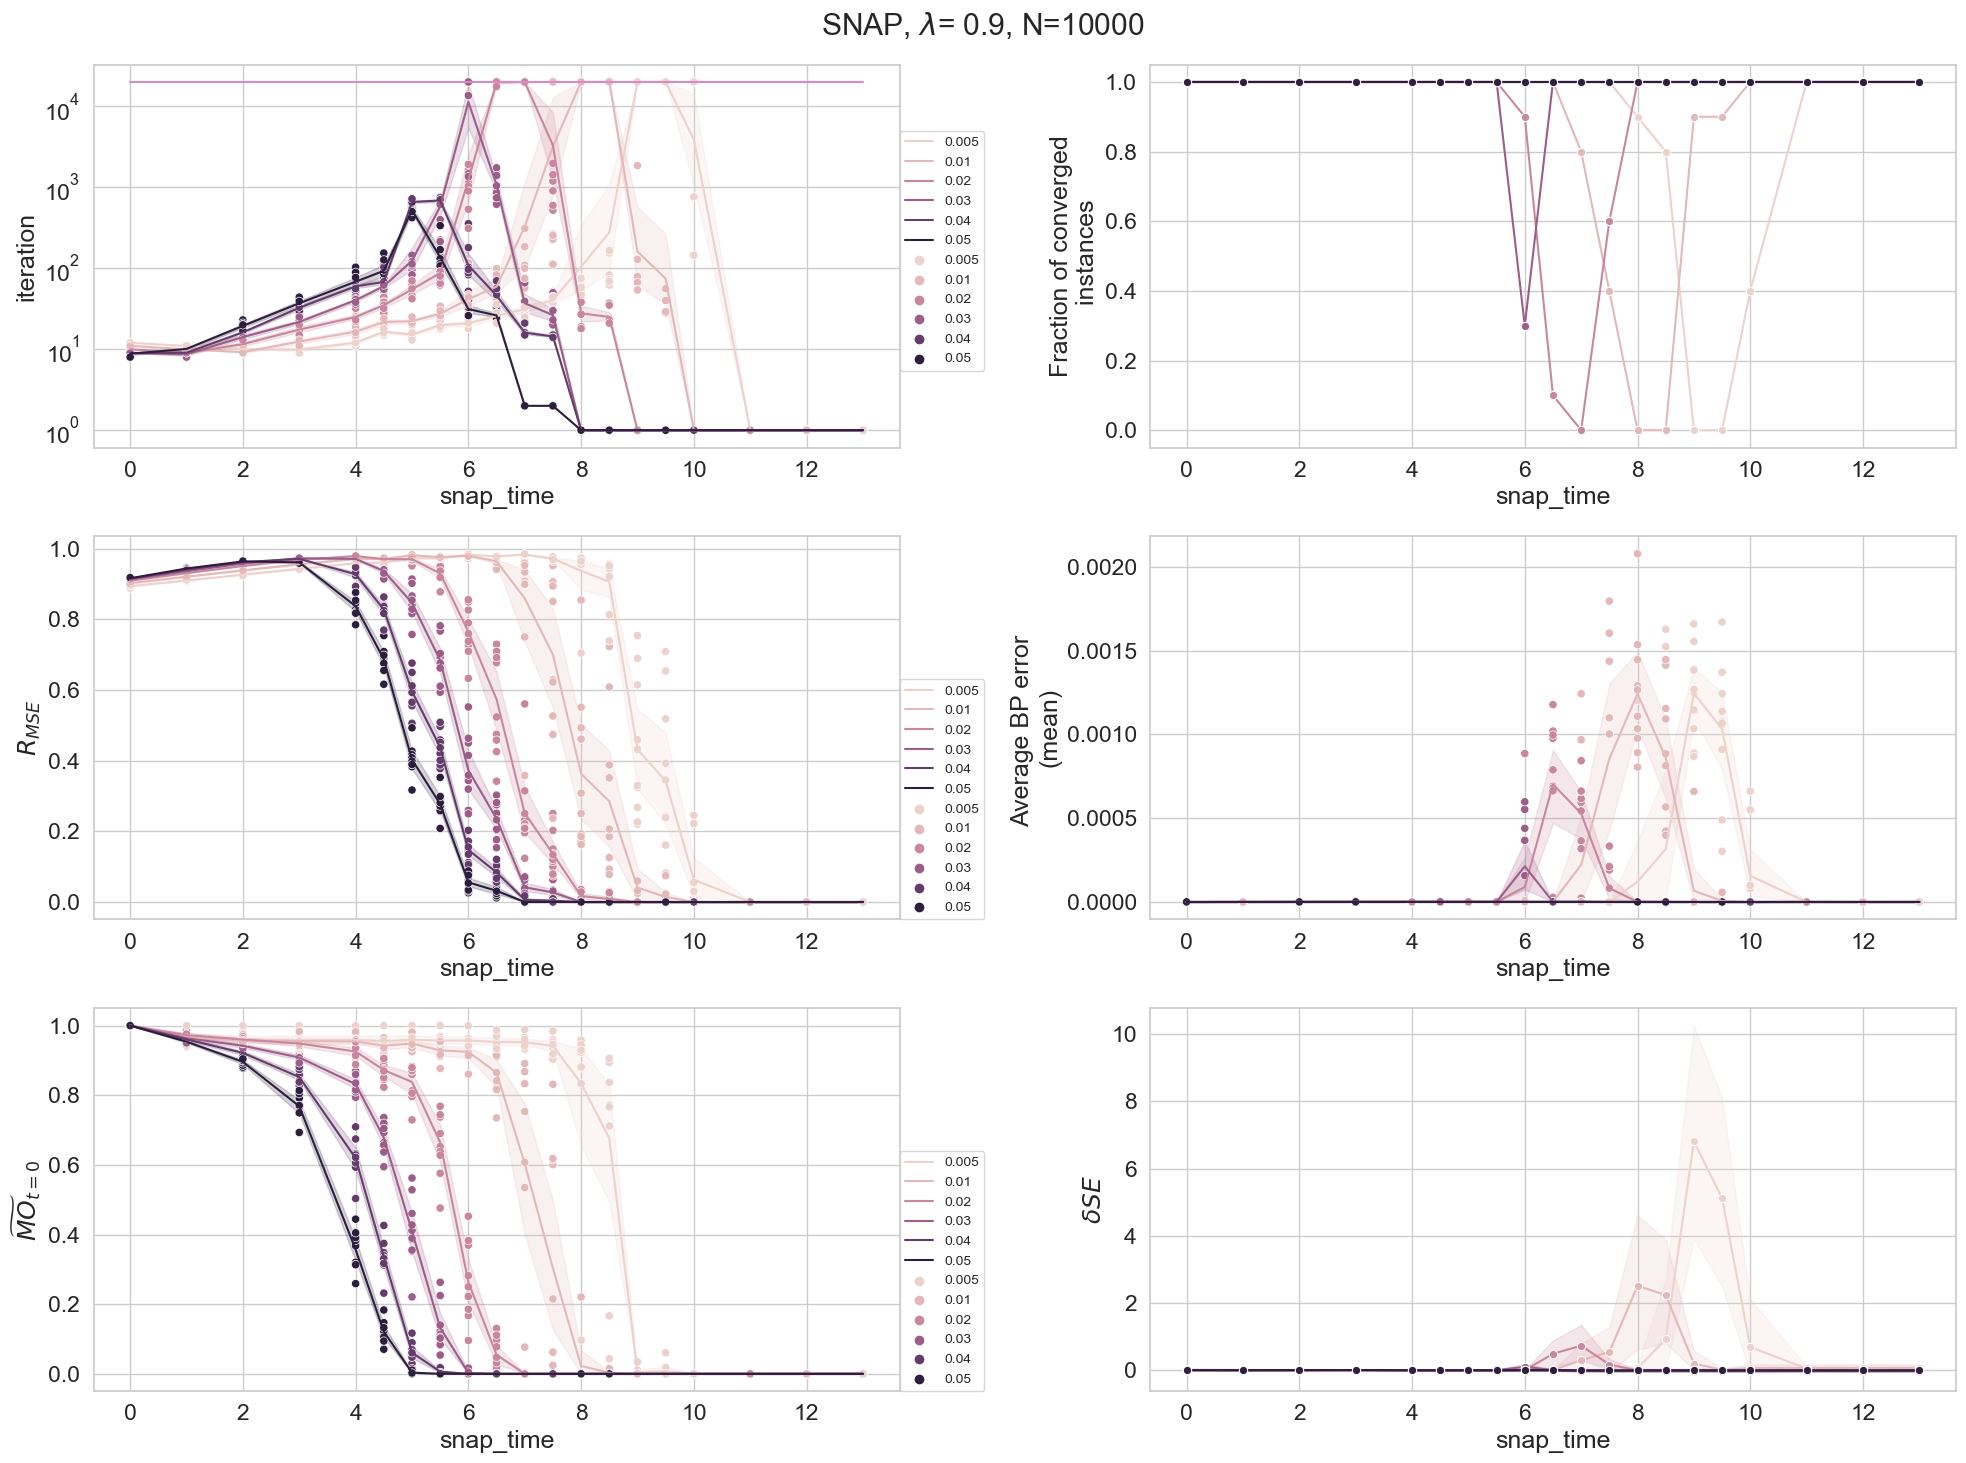

In [7]:
df_10K, df_10K_s, df_10K_l = load_df("n10K_09")
plot_df(df_10K_l)


In [8]:
miss_values(df_10K);

all values delta:0.005 
all values delta:0.01 
all values delta:0.02 
all values delta:0.03 
all values delta:0.04 
all values delta:0.05 


In [9]:
df_100K, df_100K_s, df_100K_l = load_df("n100K_09")


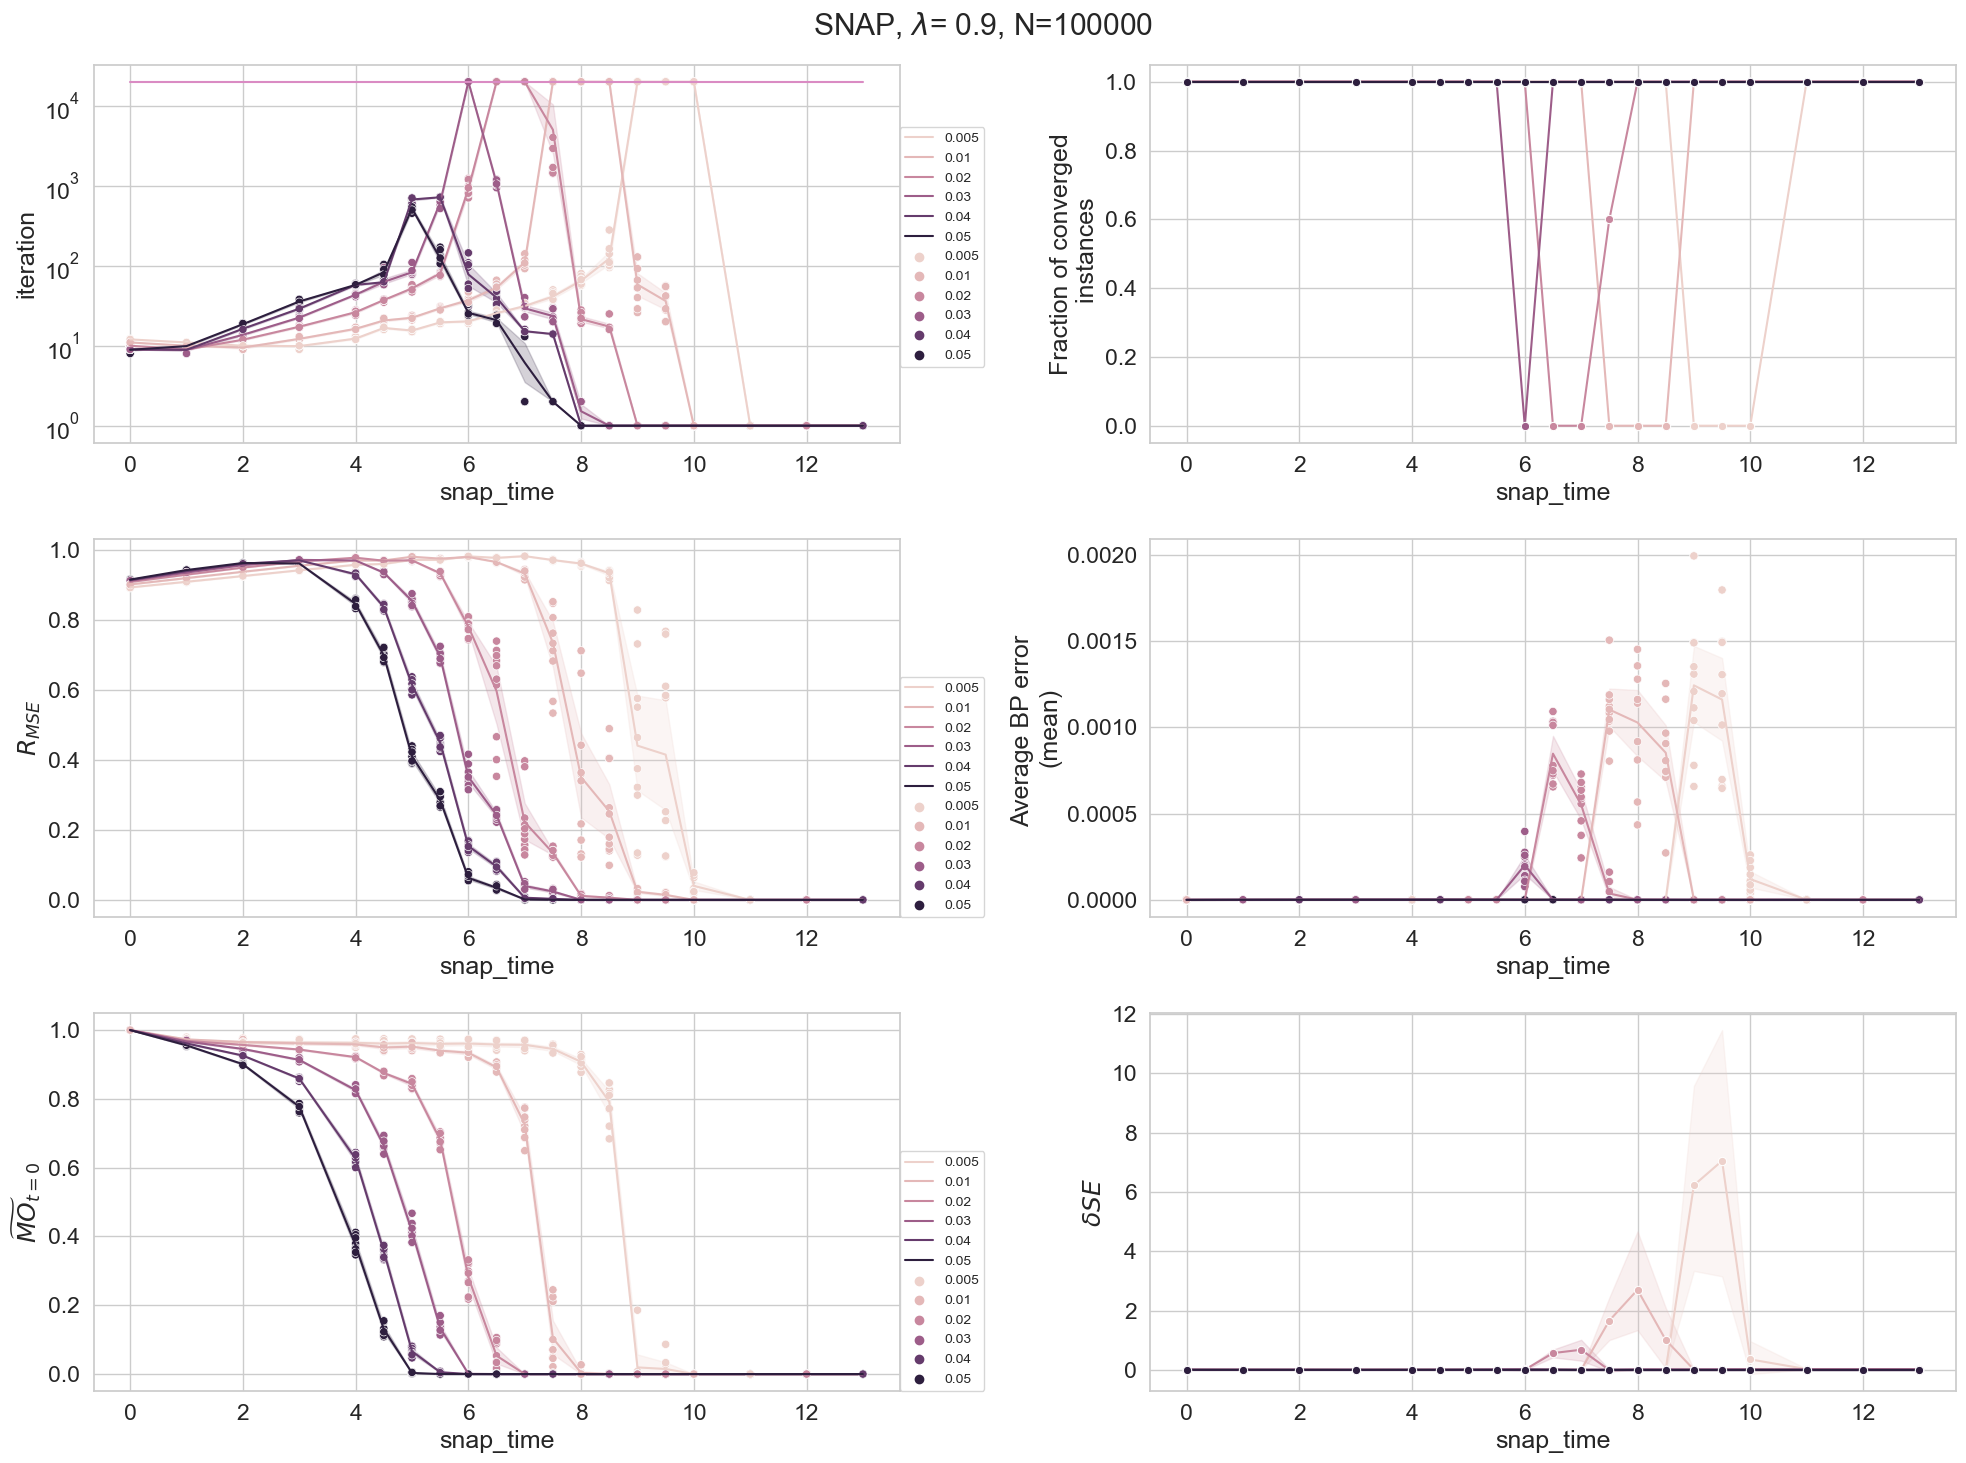

In [10]:
plot_df(df_100K_l)


In [11]:
miss_values(df_100K)

all values delta:0.005 
all values delta:0.01 
all values delta:0.02 
all values delta:0.03 
all values delta:0.04 
all values delta:0.05 


array([[20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
        20., 20., 20., 20., 20., 20., 20.],
       [20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
        20., 20., 20., 20., 20., 20., 20.],
       [20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
        20., 20., 20., 20., 20., 20., 20.],
       [20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
        20., 20., 20., 20., 20., 20., 20.],
       [20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
        20., 20., 20., 20., 20., 20., 20.],
       [20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
        20., 20., 20., 20., 20., 20., 20.]])

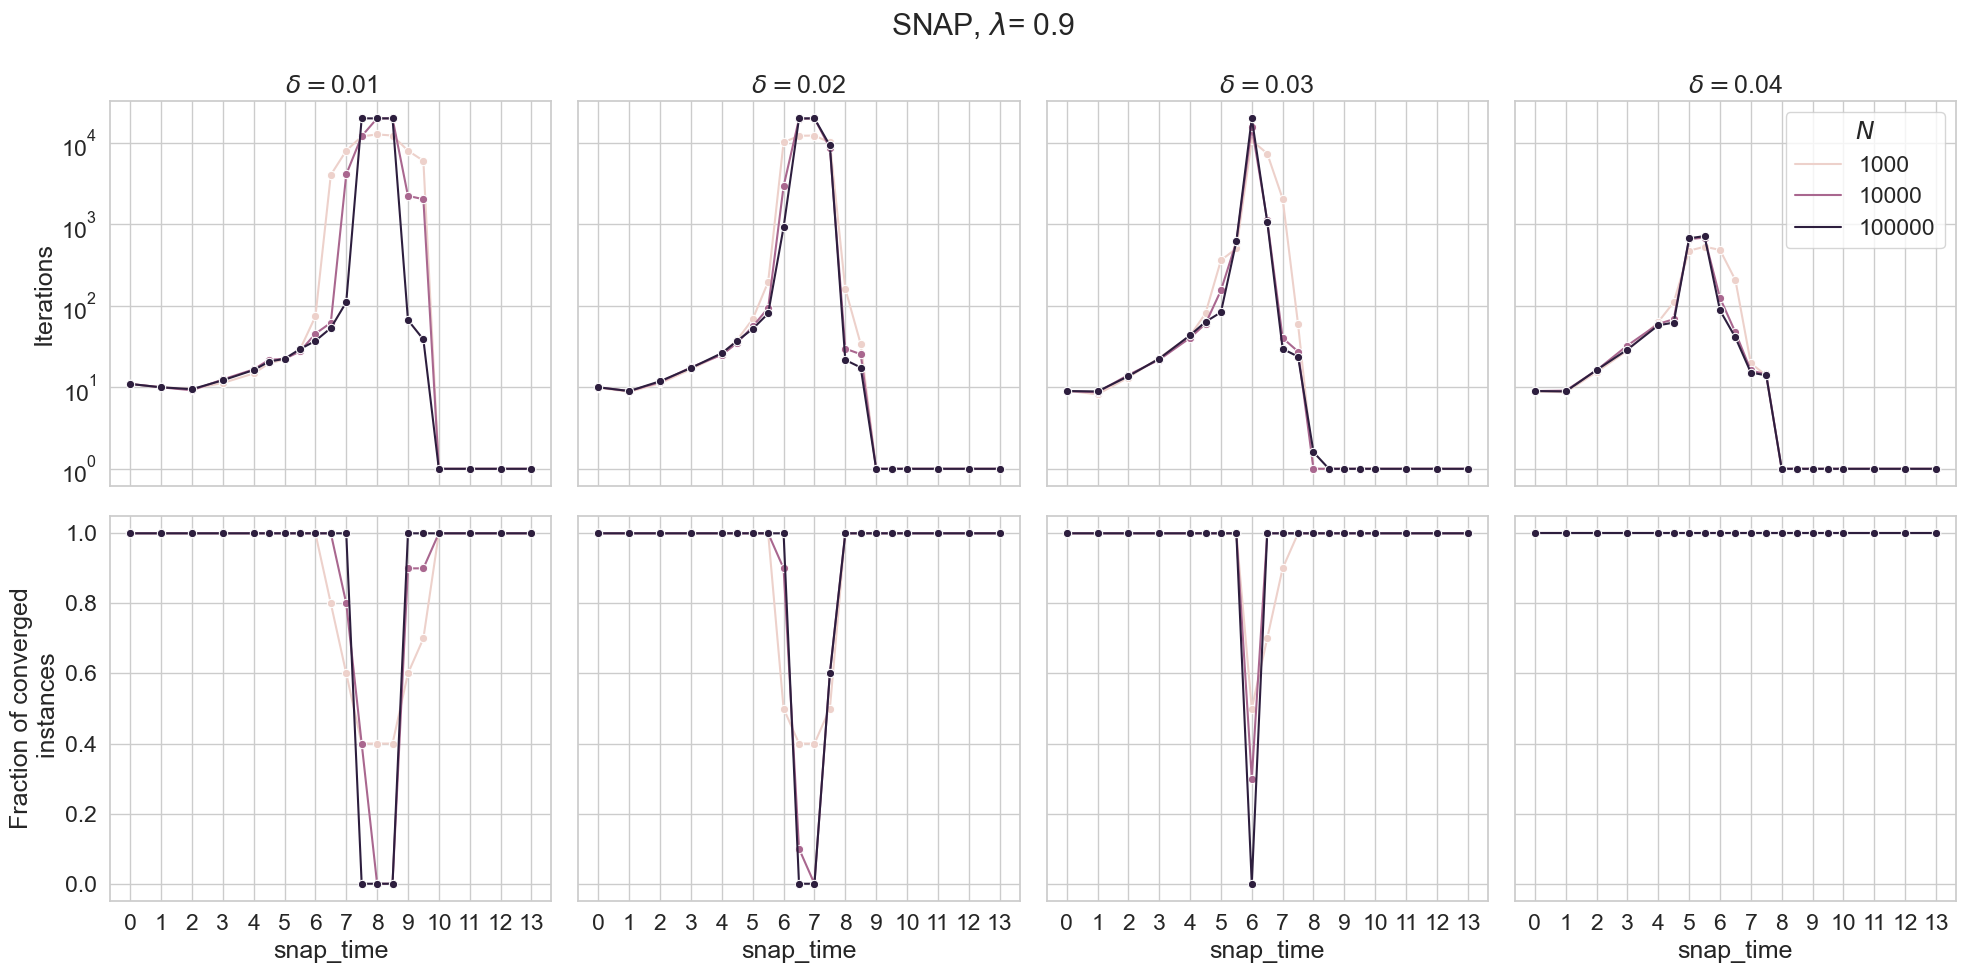

In [13]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

deltas=[0.01, 0.02, 0.03, 0.04]
fig, axs = plt.subplots(2,len(deltas), figsize=(20, 10), sharey="row", sharex=True)
plt.suptitle("SNAP, " + l_s + f"= 0.9" )

init="rnd"
all_df = pd.concat((df_100K_l, df_10K_l,df_1K_l))
for ii, dd in enumerate(deltas[:-1]):
    delta_all = all_df[(np.abs(all_df["S"]-dd)< 1e-6) & (all_df["init"]==init) ]
    sns.lineplot(data=delta_all, x=r"snap_time", hue=r"$N$", y=r"iteration",legend=None, ax=axs[0][ii], estimator="mean", errorbar=None, marker="o", hue_norm=LogNorm())
    axs[0][ii].set_title(f"$\delta=${dd}")
dd=deltas[-1]
delta_all = all_df[(np.abs(all_df["S"]-dd)< 1e-6) & (all_df["init"]==init) ]
sns.lineplot(data=delta_all, x=r"snap_time", hue=r"$N$", y=r"iteration",legend="full", ax=axs[0][3], estimator="mean", errorbar=None, marker="o", hue_norm=LogNorm())
axs[0][3].set_title(f"$\delta=${dd}")

start, end = axs[0][3].get_xlim()
axs[0][3].xaxis.set_ticks(np.arange(0, 14, 1))
axs[0][0].set_ylabel("Iterations")
axs[1][0].set_ylabel("Fraction of converged\n instances")
axs[0][0].set(yscale="log")
#axs[1][0].set(yscale="log")
#axs[2][0].set(yscale="log")
for ii, dd in enumerate(deltas):
    delta_all = all_df[(np.abs(all_df["S"]-dd)< 1e-6) & (all_df["init"]==init) ]
    sns.lineplot(data=delta_all, x=r"snap_time", hue=r"$N$", y=r"conv",legend=None, ax=axs[1][ii], estimator="mean", errorbar=None, marker="o", hue_norm=LogNorm())

# for ii, dd in enumerate(deltas):
#     delta_all = all_df[(np.abs(all_df["S"]-dd)< 1e-6) & (all_df["init"]==init) ]
#     sns.lineplot(data=delta_all, x=r"snap_time", hue=r"$N$", y=r"error",legend="full", ax=axs[2][ii], estimator="mean", errorbar=None, marker="o", hue_norm=LogNorm())

# for ii, dd in enumerate(deltas):
#     delta_all = all_df[(np.abs(all_df["S"]-dd)< 1e-6) & (all_df["init"]==init) ]
#     sns.lineplot(data=delta_all[(delta_all["conv"]==False)], x=r"snap_time", hue=r"$N$", y=r"error",legend="full", ax=axs[3][ii], estimator="mean", marker="o", hue_norm=LogNorm())

# for ii, dd in enumerate(deltas):
#     delta_all = all_df[(np.abs(all_df["S"]-dd)< 1e-6) & (all_df["init"]==init) ]
#     sns.lineplot(data=delta_all, x=r"snap_time", hue=r"$N$", y=r"$\delta SE$",legend="full", ax=axs[4][ii], estimator="mean", marker="o", hue_norm=LogNorm())

plt.tight_layout()


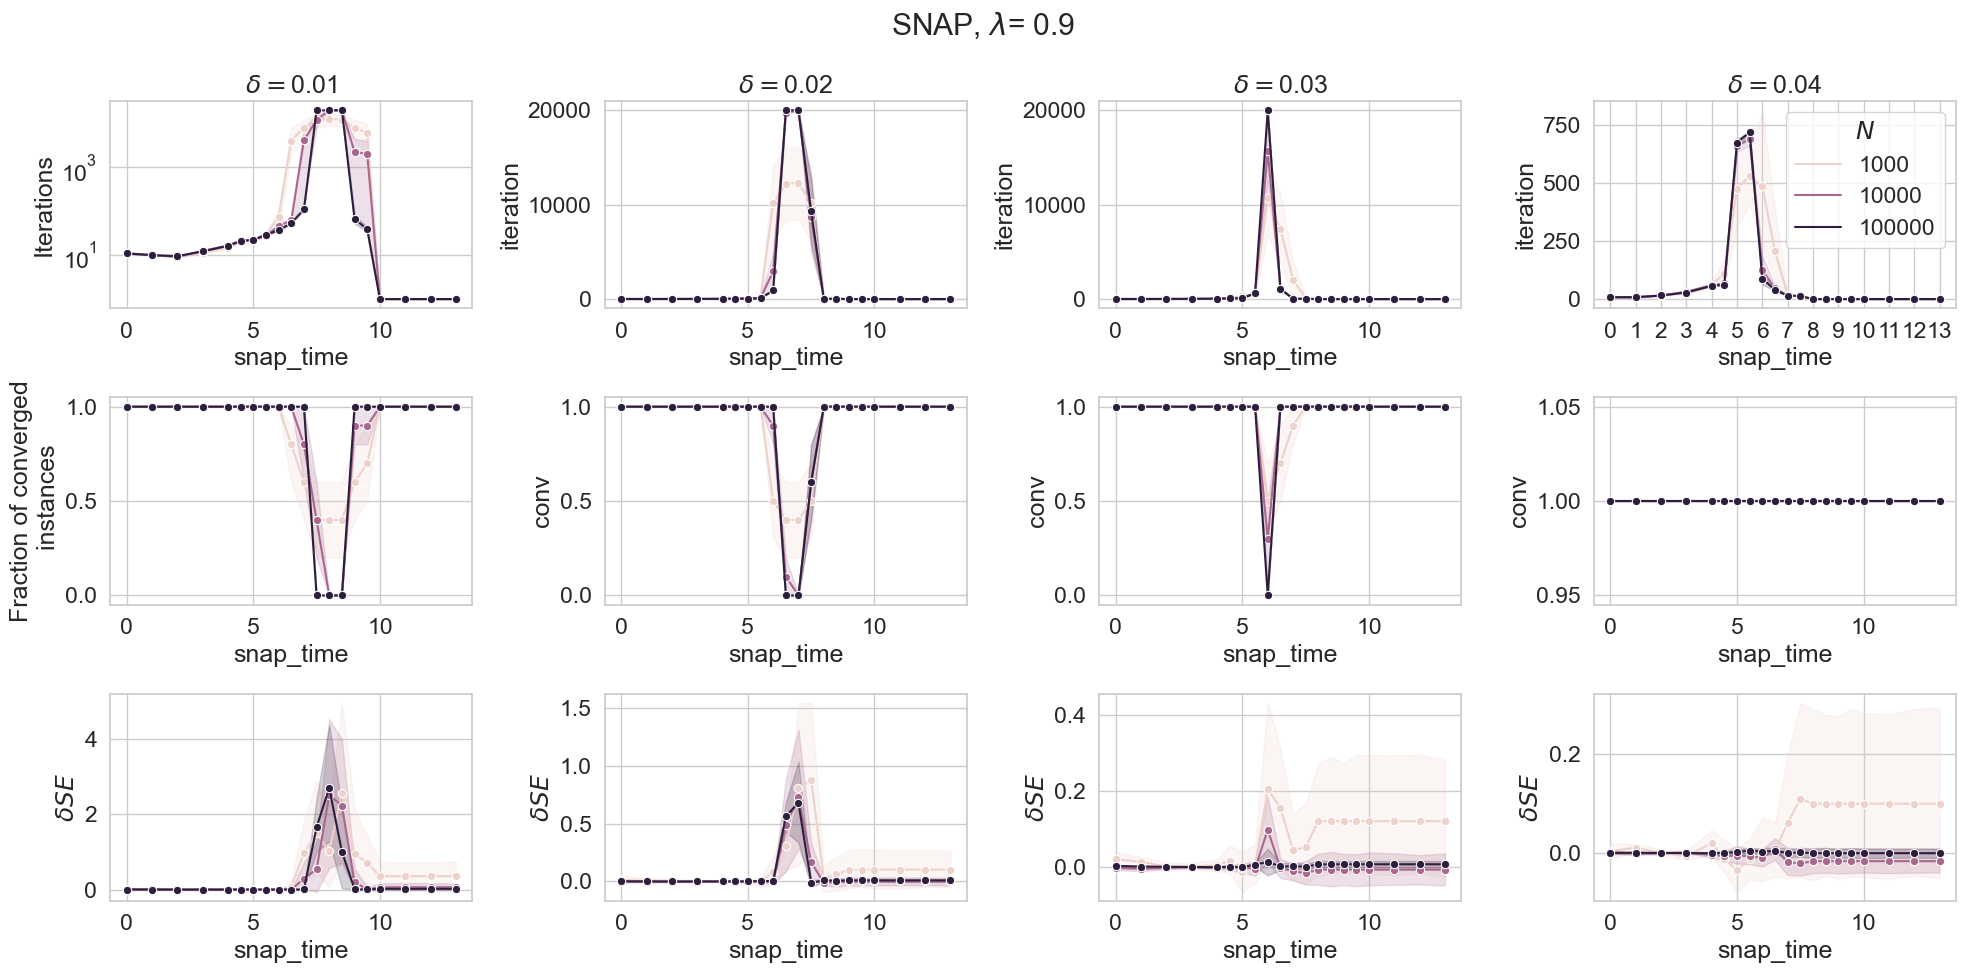

In [22]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

deltas=[0.01, 0.02, 0.03, 0.04]
fig, axs = plt.subplots(3,len(deltas), figsize=(20, 10))
plt.suptitle("SNAP, " + l_s + f"= 0.9" )

init="rnd"
all_df = pd.concat((df_100K_l, df_10K_l,df_1K_l))
for ii, dd in enumerate(deltas[:-1]):
    delta_all = all_df[(np.abs(all_df["S"]-dd)< 1e-6) & (all_df["init"]==init) ]
    sns.lineplot(data=delta_all, x=r"snap_time", hue=r"$N$", y=r"iteration",legend=None, ax=axs[0][ii], estimator="mean",  marker="o", hue_norm=LogNorm(), errorbar=('ci', 80))
    axs[0][ii].set_title(f"$\delta=${dd}")
dd=deltas[-1]
delta_all = all_df[(np.abs(all_df["S"]-dd)< 1e-6) & (all_df["init"]==init) ]
sns.lineplot(data=delta_all, x=r"snap_time", hue=r"$N$", y=r"iteration",legend="full", ax=axs[0][3], estimator="mean", marker="o", hue_norm=LogNorm())
axs[0][3].set_title(f"$\delta=${dd}")

start, end = axs[0][3].get_xlim()
axs[0][3].xaxis.set_ticks(np.arange(0, 14, 1))
axs[0][0].set_ylabel("Iterations")
axs[1][0].set_ylabel("Fraction of converged\n instances")
axs[0][0].set(yscale="log")
#axs[1][0].set(yscale="log")
#axs[2][0].set(yscale="log")
for ii, dd in enumerate(deltas):
    delta_all = all_df[(np.abs(all_df["S"]-dd)< 1e-6) & (all_df["init"]==init) ]
    sns.lineplot(data=delta_all, x=r"snap_time", hue=r"$N$", y=r"conv",legend=None, ax=axs[1][ii], estimator="mean", marker="o", hue_norm=LogNorm(), errorbar=('ci', 80))


for ii, dd in enumerate(deltas):
    delta_all = all_df[(np.abs(all_df["S"]-dd)< 1e-6) & (all_df["init"]==init) ]
    sns.lineplot(data=delta_all, x=r"snap_time", hue=r"$N$", y=r"$\delta SE$",legend=None, ax=axs[2][ii], estimator="mean",marker="o", hue_norm=LogNorm())

# for ii, dd in enumerate(deltas):
#     delta_all = all_df[(np.abs(all_df["S"]-dd)< 1e-6) & (all_df["init"]==init) ]
#     sns.lineplot(data=delta_all, x=r"snap_time", hue=r"$N$", y=r"error",legend="full", ax=axs[2][ii], estimator="mean", errorbar=None, marker="o", hue_norm=LogNorm())

# for ii, dd in enumerate(deltas):
#     delta_all = all_df[(np.abs(all_df["S"]-dd)< 1e-6) & (all_df["init"]==init) ]
#     sns.lineplot(data=delta_all[(delta_all["conv"]==False)], x=r"snap_time", hue=r"$N$", y=r"error",legend="full", ax=axs[3][ii], estimator="mean", marker="o", hue_norm=LogNorm())

# for ii, dd in enumerate(deltas):
#     delta_all = all_df[(np.abs(all_df["S"]-dd)< 1e-6) & (all_df["init"]==init) ]
#     sns.lineplot(data=delta_all, x=r"snap_time", hue=r"$N$", y=r"$\delta SE$",legend="full", ax=axs[4][ii], estimator="mean", marker="o", hue_norm=LogNorm())

plt.tight_layout()


In [29]:
all_df.keys()

Index(['init', 'graph_type', '$N$', '$d$', '$\lambda$', 's_type', 'S',
       'o_type', 'M', 'iter_space', 'seed', 'tol', 'n_iter', 'obs_type',
       'snap_time', 'T_max', 'mask_type', '$\mu$', 'tol2', 'it_max', '$T$',
       '$f_S$', '$f_I$', '$T_O$', '$\Delta$', 'damping', 'error', 'iteration',
       'it_final', 'logL', '$O_{t=0}$', '$O_{t=0,RND}$', '$MO_{t=0}$',
       '$MO_{t=0,RND}$', '$\delta O_{t=0}$', '$\widetilde{O}_{t=0}$',
       '$\widetilde{MO}_{t=0}$', '$\widetilde{\delta O}_{t=0}$', '$O_{t=T}$',
       '$O_{t=T,RND}$', '$MO_{t=T}$', '$MO_{t=T,RND}$', '$\delta O_{t=T}$',
       '$\widetilde{O}_{t=T}$', '$\widetilde{MO}_{t=T}$',
       '$\widetilde{\delta O}_{t=T}$', 'SE', 'MSE', '$SE_{RND}$',
       '$MSE_{RND}$', '$\delta SE$', '$R_{SE}$', '$R_{MSE}$',
       '$\delta R_{SE}$', 'ConvChecks', '$\rho$', 'conv', '$\delta$'],
      dtype='object')

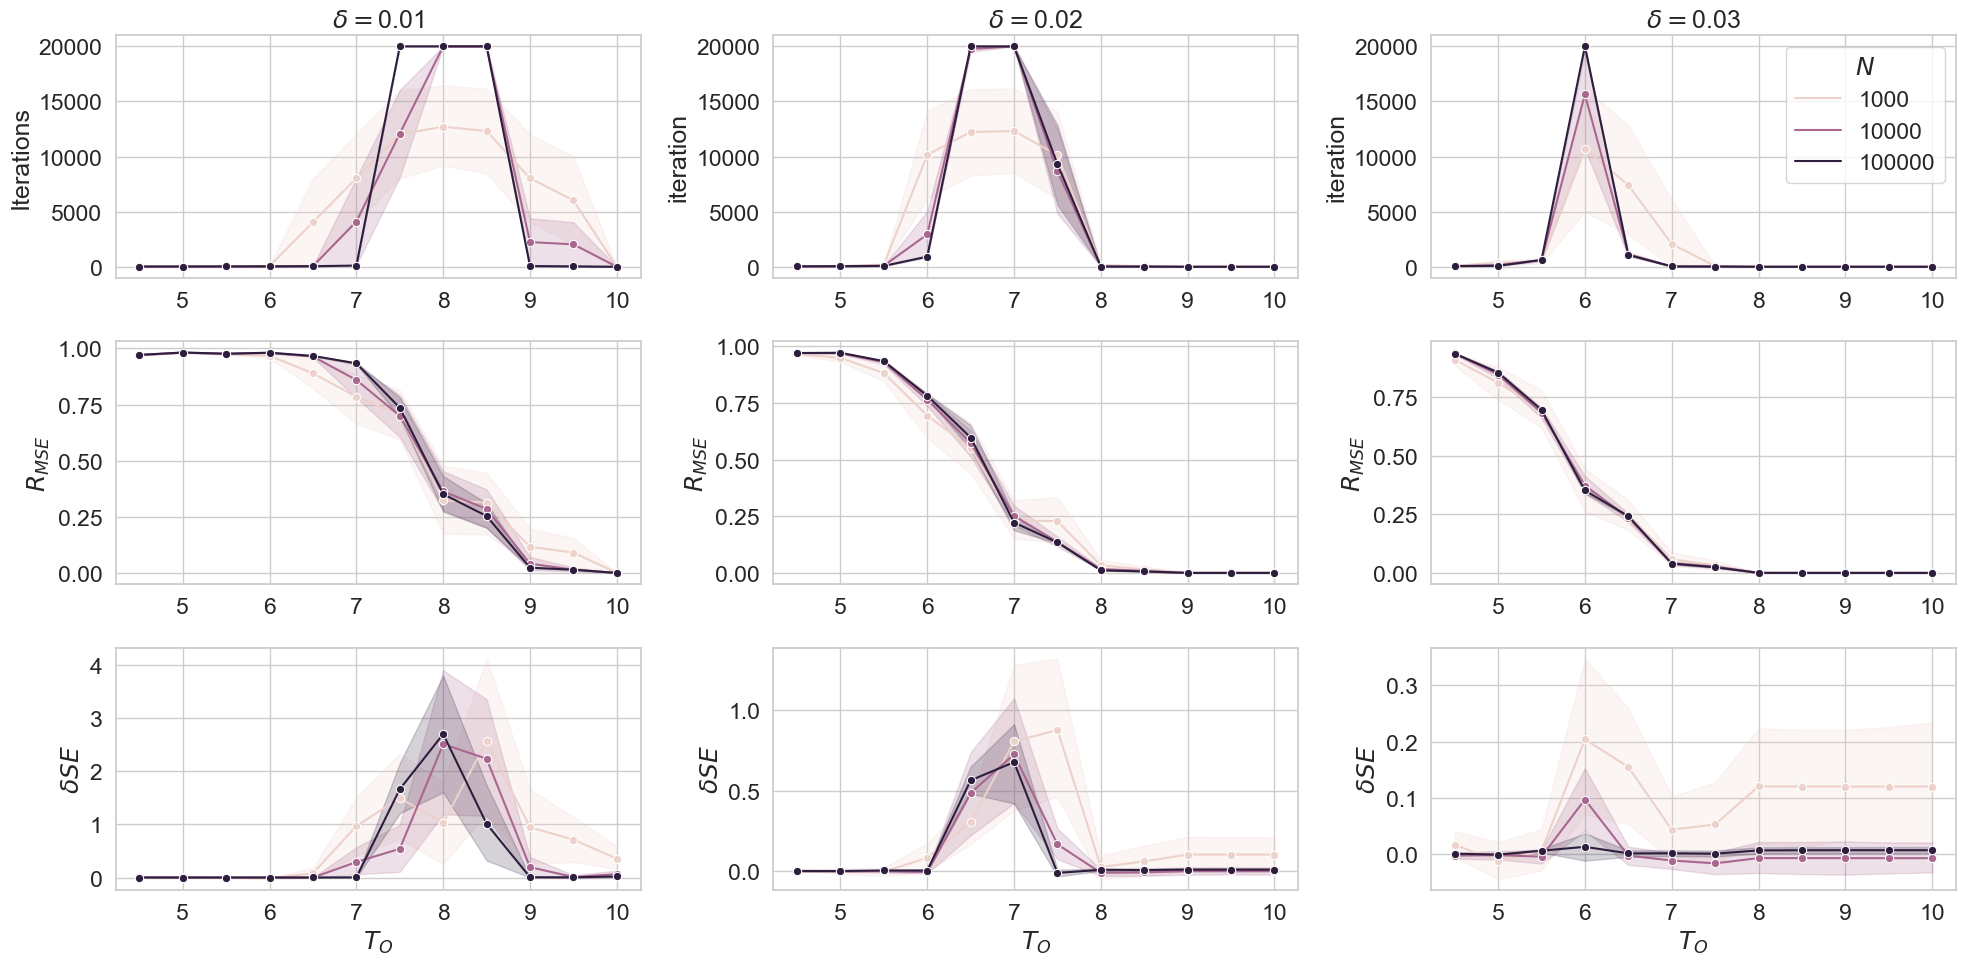

In [38]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

deltas=[0.01, 0.02, 0.03]
fig, axs = plt.subplots(3,len(deltas), figsize=(20, 10))
#plt.suptitle("SNAP, " + l_s + f"= 0.9" )

init="rnd"
all_df = pd.concat((df_100K_l, df_10K_l,df_1K_l))

for ii, dd in enumerate(deltas[:-1]):
    delta_all = all_df[(np.abs(all_df["S"]-dd)< 1e-6) & (all_df["init"]==init) & (all_df["$T_O$"]<=10) & (all_df["$T_O$"]>=5)]
    sns.lineplot(data=delta_all, x=r"snap_time", hue=r"$N$", y=r"iteration",legend=None, ax=axs[0][ii], estimator="mean",  marker="o", hue_norm=LogNorm(), errorbar=('ci', 80))
    axs[0][ii].set_title(f"$\delta=${dd}")
    
dd=deltas[-1]
delta_all = all_df[(np.abs(all_df["S"]-dd)< 1e-6) & (all_df["init"]==init)  & (all_df["$T_O$"]<=10) & (all_df["$T_O$"]>=5)]
sns.lineplot(data=delta_all, x=r"snap_time", hue=r"$N$", y=r"iteration",legend="full", ax=axs[0][-1], estimator="mean", marker="o", hue_norm=LogNorm())
axs[0][-1].set_title(f"$\delta=${dd}")

start, end = axs[0][-1].get_xlim()
#axs[0][-1].xaxis.set_ticks(np.arange(0, 14, 1))
axs[0][0].set_ylabel("Iterations")
#axs[1][0].set_ylabel("Fraction of converged\n instances")
#axs[0][0].set(yscale="log")
#axs[1][0].set(yscale="log")
#axs[2][0].set(yscale="log")

for ii, dd in enumerate(deltas):
    delta_all = all_df[(np.abs(all_df["S"]-dd)< 1e-6) & (all_df["init"]==init) & (all_df["$T_O$"]<=10) & (all_df["$T_O$"]>=5) ]
    sns.lineplot(data=delta_all, x=r"snap_time", hue=r"$N$", y=r"$R_{MSE}$",legend=None, ax=axs[1][ii], estimator="mean",marker="o", hue_norm=LogNorm(), errorbar=('ci', 80))


for ii, dd in enumerate(deltas):
    delta_all = all_df[(np.abs(all_df["S"]-dd)< 1e-6) & (all_df["init"]==init) & (all_df["$T_O$"]<=10) & (all_df["$T_O$"]>=5) ]
    sns.lineplot(data=delta_all, x=r"snap_time", hue=r"$N$", y=r"$\delta SE$",legend=None, ax=axs[2][ii], estimator="mean",marker="o", hue_norm=LogNorm(), errorbar=('ci', 80))

for i in range(3):
    for j in range(len(deltas)):
        axs[i][j].set(xlabel=None)
for i in range(3):
    axs[-1][i].set_xlabel(r"${T_O}$")
# for ii, dd in enumerate(deltas):
#     delta_all = all_df[(np.abs(all_df["S"]-dd)< 1e-6) & (all_df["init"]==init) ]
#     sns.lineplot(data=delta_all, x=r"snap_time", hue=r"$N$", y=r"error",legend="full", ax=axs[2][ii], estimator="mean", errorbar=None, marker="o", hue_norm=LogNorm())

# for ii, dd in enumerate(deltas):
#     delta_all = all_df[(np.abs(all_df["S"]-dd)< 1e-6) & (all_df["init"]==init) ]
#     sns.lineplot(data=delta_all[(delta_all["conv"]==False)], x=r"snap_time", hue=r"$N$", y=r"error",legend="full", ax=axs[3][ii], estimator="mean", marker="o", hue_norm=LogNorm())

# for ii, dd in enumerate(deltas):
#     delta_all = all_df[(np.abs(all_df["S"]-dd)< 1e-6) & (all_df["init"]==init) ]
#     sns.lineplot(data=delta_all, x=r"snap_time", hue=r"$N$", y=r"$\delta SE$",legend="full", ax=axs[4][ii], estimator="mean", marker="o", hue_norm=LogNorm())

plt.tight_layout()


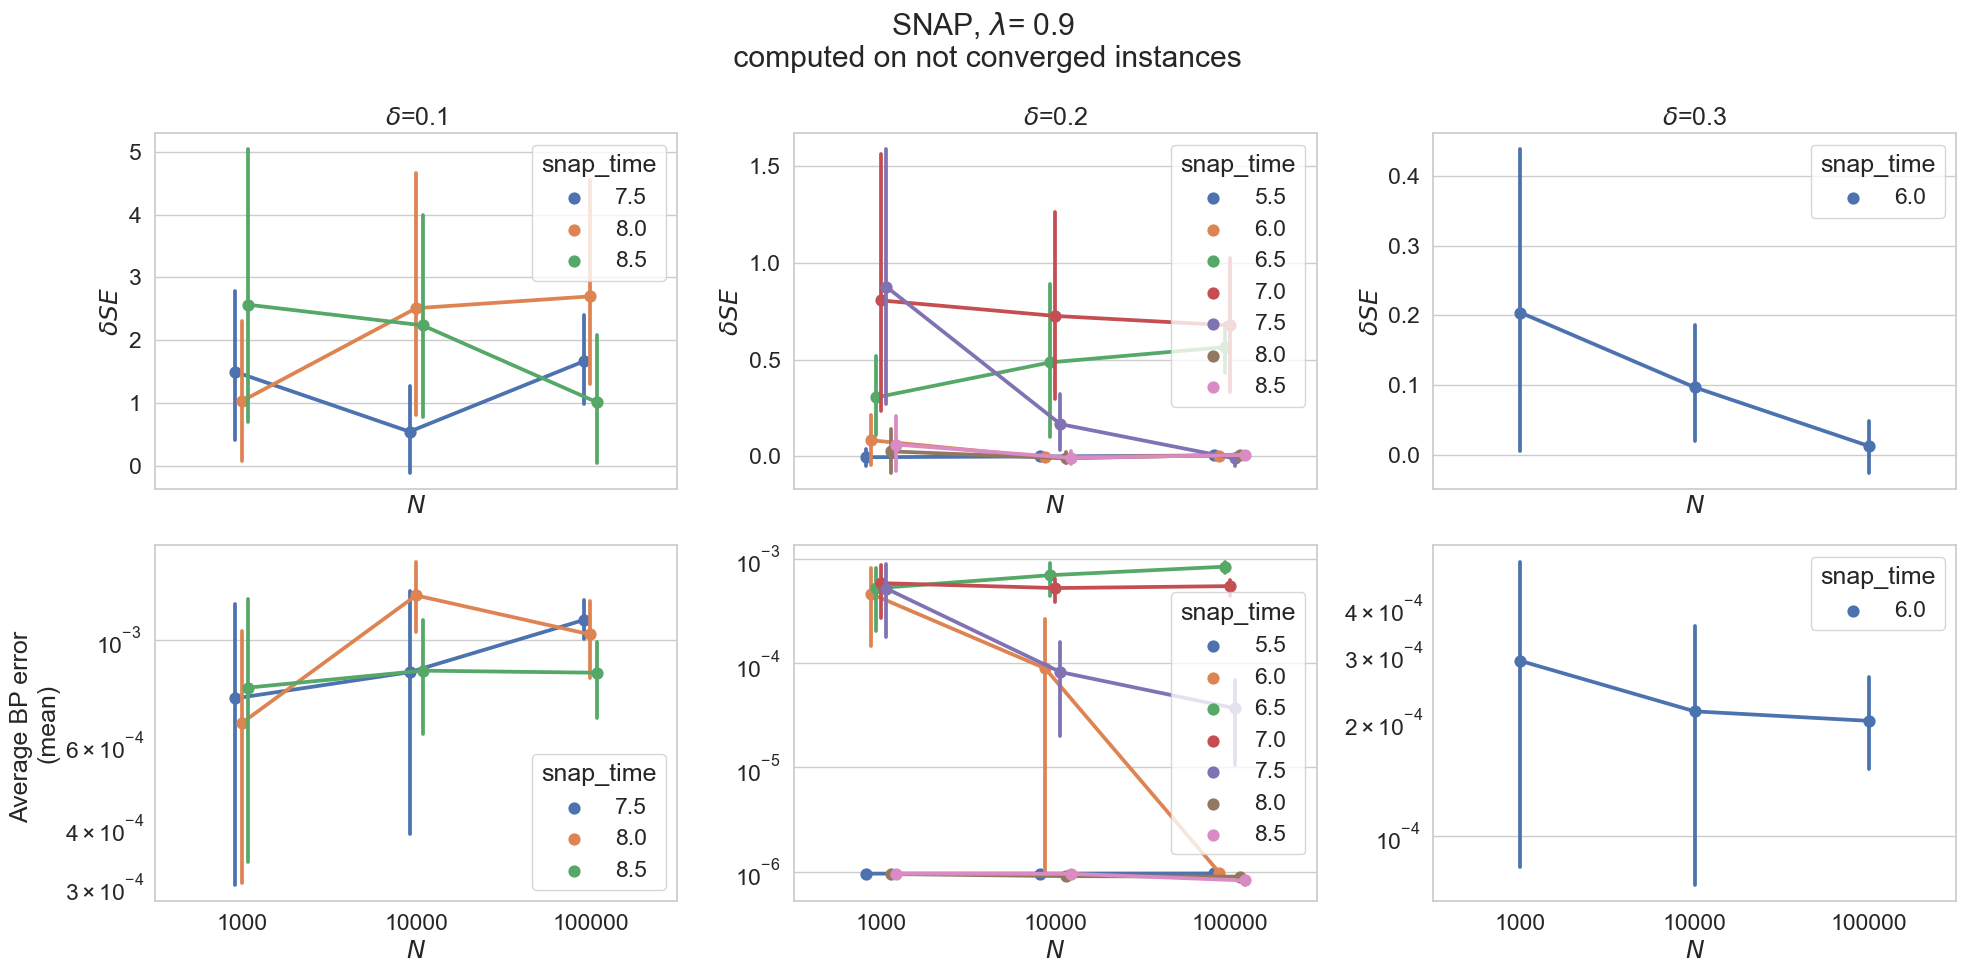

In [15]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm



deltas=[0.01, 0.02, 0.03]
snap_times=[9, 10, 11,12, 13]
fig, axs = plt.subplots(2,len(deltas), figsize=(20, 10), sharex=True)
init="rnd"
#axs[0][0].set(yscale="log")
plt.suptitle("SNAP, " + l_s + f"= 0.9" + "\n computed on not converged instances")

dd=deltas[0]
delta_all = all_df[(np.abs(all_df["snap_time"]<=8.5)) & (np.abs(all_df["snap_time"]>=7.5)) & (all_df["init"]==init) & (np.abs(all_df["S"]-dd)< 1e-6) ]
sns.pointplot(data=delta_all, x=r"$N$", y=r"$\delta SE$", hue="snap_time", ax=axs[0][0], dodge=True)
#axs[0][0].set(xscale="log")
axs[0][0].set_title(r"$\delta$=0.1")
axs[0][1].set_title(r"$\delta$=0.2")
axs[0][2].set_title(r"$\delta$=0.3")

dd=deltas[1]
delta_all = all_df[(np.abs(all_df["snap_time"]<=8.5)) & (np.abs(all_df["snap_time"]>=5.5)) & (all_df["init"]==init) & (np.abs(all_df["S"]-dd)< 1e-6)  ]
sns.pointplot(data=delta_all, x=r"$N$", y=r"$\delta SE$", hue="snap_time", ax=axs[0][1], dodge=True)
#sns.lineplot(data=delta_all, x=r"$N$", y=r"$\delta SE$",legend="full", hue="snap_time", ax=axs[0][1], estimator="mean", marker="o", hue_norm=LogNorm(), err_style="bars")
#axs[0][1].set(xscale="log")

dd=deltas[2]
delta_all = all_df[(np.abs(all_df["snap_time"]<=6.)) & (np.abs(all_df["snap_time"]>=6.)) & (all_df["init"]==init) & (np.abs(all_df["S"]-dd)< 1e-6) ]
sns.pointplot(data=delta_all, x=r"$N$", y=r"$\delta SE$", hue="snap_time", ax=axs[0][2], dodge=True)

dd=deltas[0]
delta_all = all_df[(np.abs(all_df["snap_time"]<=8.5)) & (np.abs(all_df["snap_time"]>=7.5)) & (all_df["init"]==init) & (np.abs(all_df["S"]-dd)< 1e-6) ]
sns.pointplot(data=delta_all, x=r"$N$", y=r"error", hue="snap_time", ax=axs[1][0], dodge=True)
axs[1][0].set(yscale="log")

dd=deltas[1]
delta_all = all_df[(np.abs(all_df["snap_time"]<=8.5)) & (np.abs(all_df["snap_time"]>=5.5)) & (all_df["init"]==init) & (np.abs(all_df["S"]-dd)< 1e-6) ]
sns.pointplot(data=delta_all, x=r"$N$", y=r"error", hue="snap_time", ax=axs[1][1], dodge=True)
#sns.lineplot(data=delta_all, x=r"$N$", y=r"$\delta SE$",legend="full", hue="snap_time", ax=axs[0][1], estimator="mean", marker="o", hue_norm=LogNorm(), err_style="bars")
axs[1][1].set(yscale="log")

dd=deltas[2]
delta_all = all_df[(np.abs(all_df["snap_time"]<=6.)) & (np.abs(all_df["snap_time"]>=6.)) & (all_df["init"]==init) & (np.abs(all_df["S"]-dd)< 1e-6) ]
sns.pointplot(data=delta_all, x=r"$N$", y=r"error", hue="snap_time", ax=axs[1][2], dodge=True)
axs[1][2].set(yscale="log")
b=9e-5
u=2e-3
axs[1][0].set_ylabel("Average BP error \n(mean)")
axs[1][1].set_ylabel("")
axs[1][2].set_ylabel("")

#axs[1][0].set_ylim(b, u)
#axs[1][1].set_ylim(b, u)
#axs[1][2].set_ylim(b, u)
plt.tight_layout()



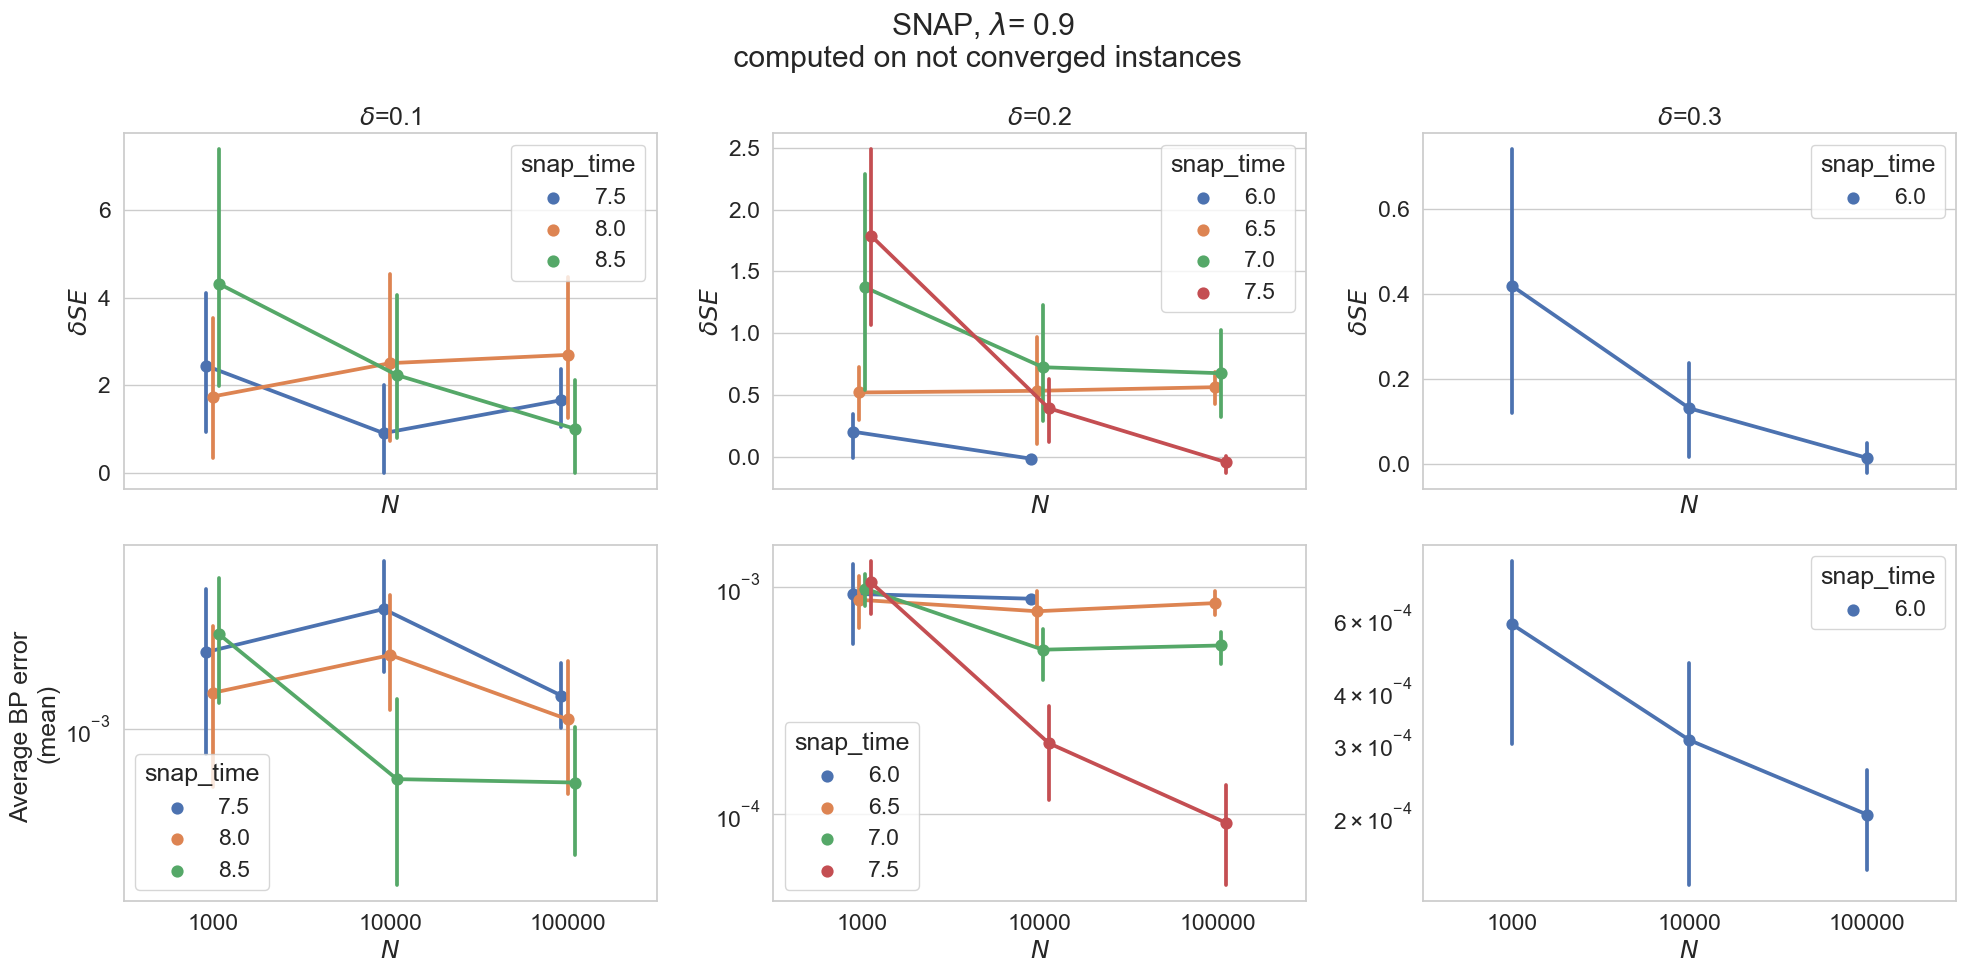

In [14]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm



deltas=[0.01, 0.02, 0.03]
snap_times=[9, 10, 11,12, 13]
fig, axs = plt.subplots(2,len(deltas), figsize=(20, 10), sharex=True)
init="rnd"
#axs[0][0].set(yscale="log")
plt.suptitle("SNAP, " + l_s + f"= 0.9" + "\n computed on not converged instances")

dd=deltas[0]
delta_all = all_df[(np.abs(all_df["snap_time"]<=8.5)) & (np.abs(all_df["snap_time"]>=7.5)) & (all_df["init"]==init) & (np.abs(all_df["S"]-dd)< 1e-6) & (all_df["conv"]==False) ]
sns.pointplot(data=delta_all, x=r"$N$", y=r"$\delta SE$", hue="snap_time", ax=axs[0][0], dodge=True)
#axs[0][0].set(xscale="log")
axs[0][0].set_title(r"$\delta$=0.1")
axs[0][1].set_title(r"$\delta$=0.2")
axs[0][2].set_title(r"$\delta$=0.3")

dd=deltas[1]
delta_all = all_df[(np.abs(all_df["snap_time"]<=8.5)) & (np.abs(all_df["snap_time"]>=5.5)) & (all_df["init"]==init) & (np.abs(all_df["S"]-dd)< 1e-6)  & (all_df["conv"]==False) ]
sns.pointplot(data=delta_all, x=r"$N$", y=r"$\delta SE$", hue="snap_time", ax=axs[0][1], dodge=True)
#sns.lineplot(data=delta_all, x=r"$N$", y=r"$\delta SE$",legend="full", hue="snap_time", ax=axs[0][1], estimator="mean", marker="o", hue_norm=LogNorm(), err_style="bars")
#axs[0][1].set(xscale="log")

dd=deltas[2]
delta_all = all_df[(np.abs(all_df["snap_time"]<=6.)) & (np.abs(all_df["snap_time"]>=6.)) & (all_df["init"]==init) & (np.abs(all_df["S"]-dd)< 1e-6)  & (all_df["conv"]==False) ]
sns.pointplot(data=delta_all, x=r"$N$", y=r"$\delta SE$", hue="snap_time", ax=axs[0][2], dodge=True)

dd=deltas[0]
delta_all = all_df[(np.abs(all_df["snap_time"]<=8.5)) & (np.abs(all_df["snap_time"]>=7.5)) & (all_df["init"]==init) & (np.abs(all_df["S"]-dd)< 1e-6) & (all_df["conv"]==False) ]
sns.pointplot(data=delta_all, x=r"$N$", y=r"error", hue="snap_time", ax=axs[1][0], dodge=True)
axs[1][0].set(yscale="log")

dd=deltas[1]
delta_all = all_df[(np.abs(all_df["snap_time"]<=8.5)) & (np.abs(all_df["snap_time"]>=5.5)) & (all_df["init"]==init) & (np.abs(all_df["S"]-dd)< 1e-6)  & (all_df["conv"]==False) ]
sns.pointplot(data=delta_all, x=r"$N$", y=r"error", hue="snap_time", ax=axs[1][1], dodge=True)
#sns.lineplot(data=delta_all, x=r"$N$", y=r"$\delta SE$",legend="full", hue="snap_time", ax=axs[0][1], estimator="mean", marker="o", hue_norm=LogNorm(), err_style="bars")
axs[1][1].set(yscale="log")

dd=deltas[2]
delta_all = all_df[(np.abs(all_df["snap_time"]<=6.)) & (np.abs(all_df["snap_time"]>=6.)) & (all_df["init"]==init) & (np.abs(all_df["S"]-dd)< 1e-6)  & (all_df["conv"]==False) ]
sns.pointplot(data=delta_all, x=r"$N$", y=r"error", hue="snap_time", ax=axs[1][2], dodge=True)
axs[1][2].set(yscale="log")
b=9e-5
u=2e-3
axs[1][0].set_ylabel("Average BP error \n(mean)")
axs[1][1].set_ylabel("")
axs[1][2].set_ylabel("")

#axs[1][0].set_ylim(b, u)
#axs[1][1].set_ylim(b, u)
#axs[1][2].set_ylim(b, u)
plt.tight_layout()



[None]

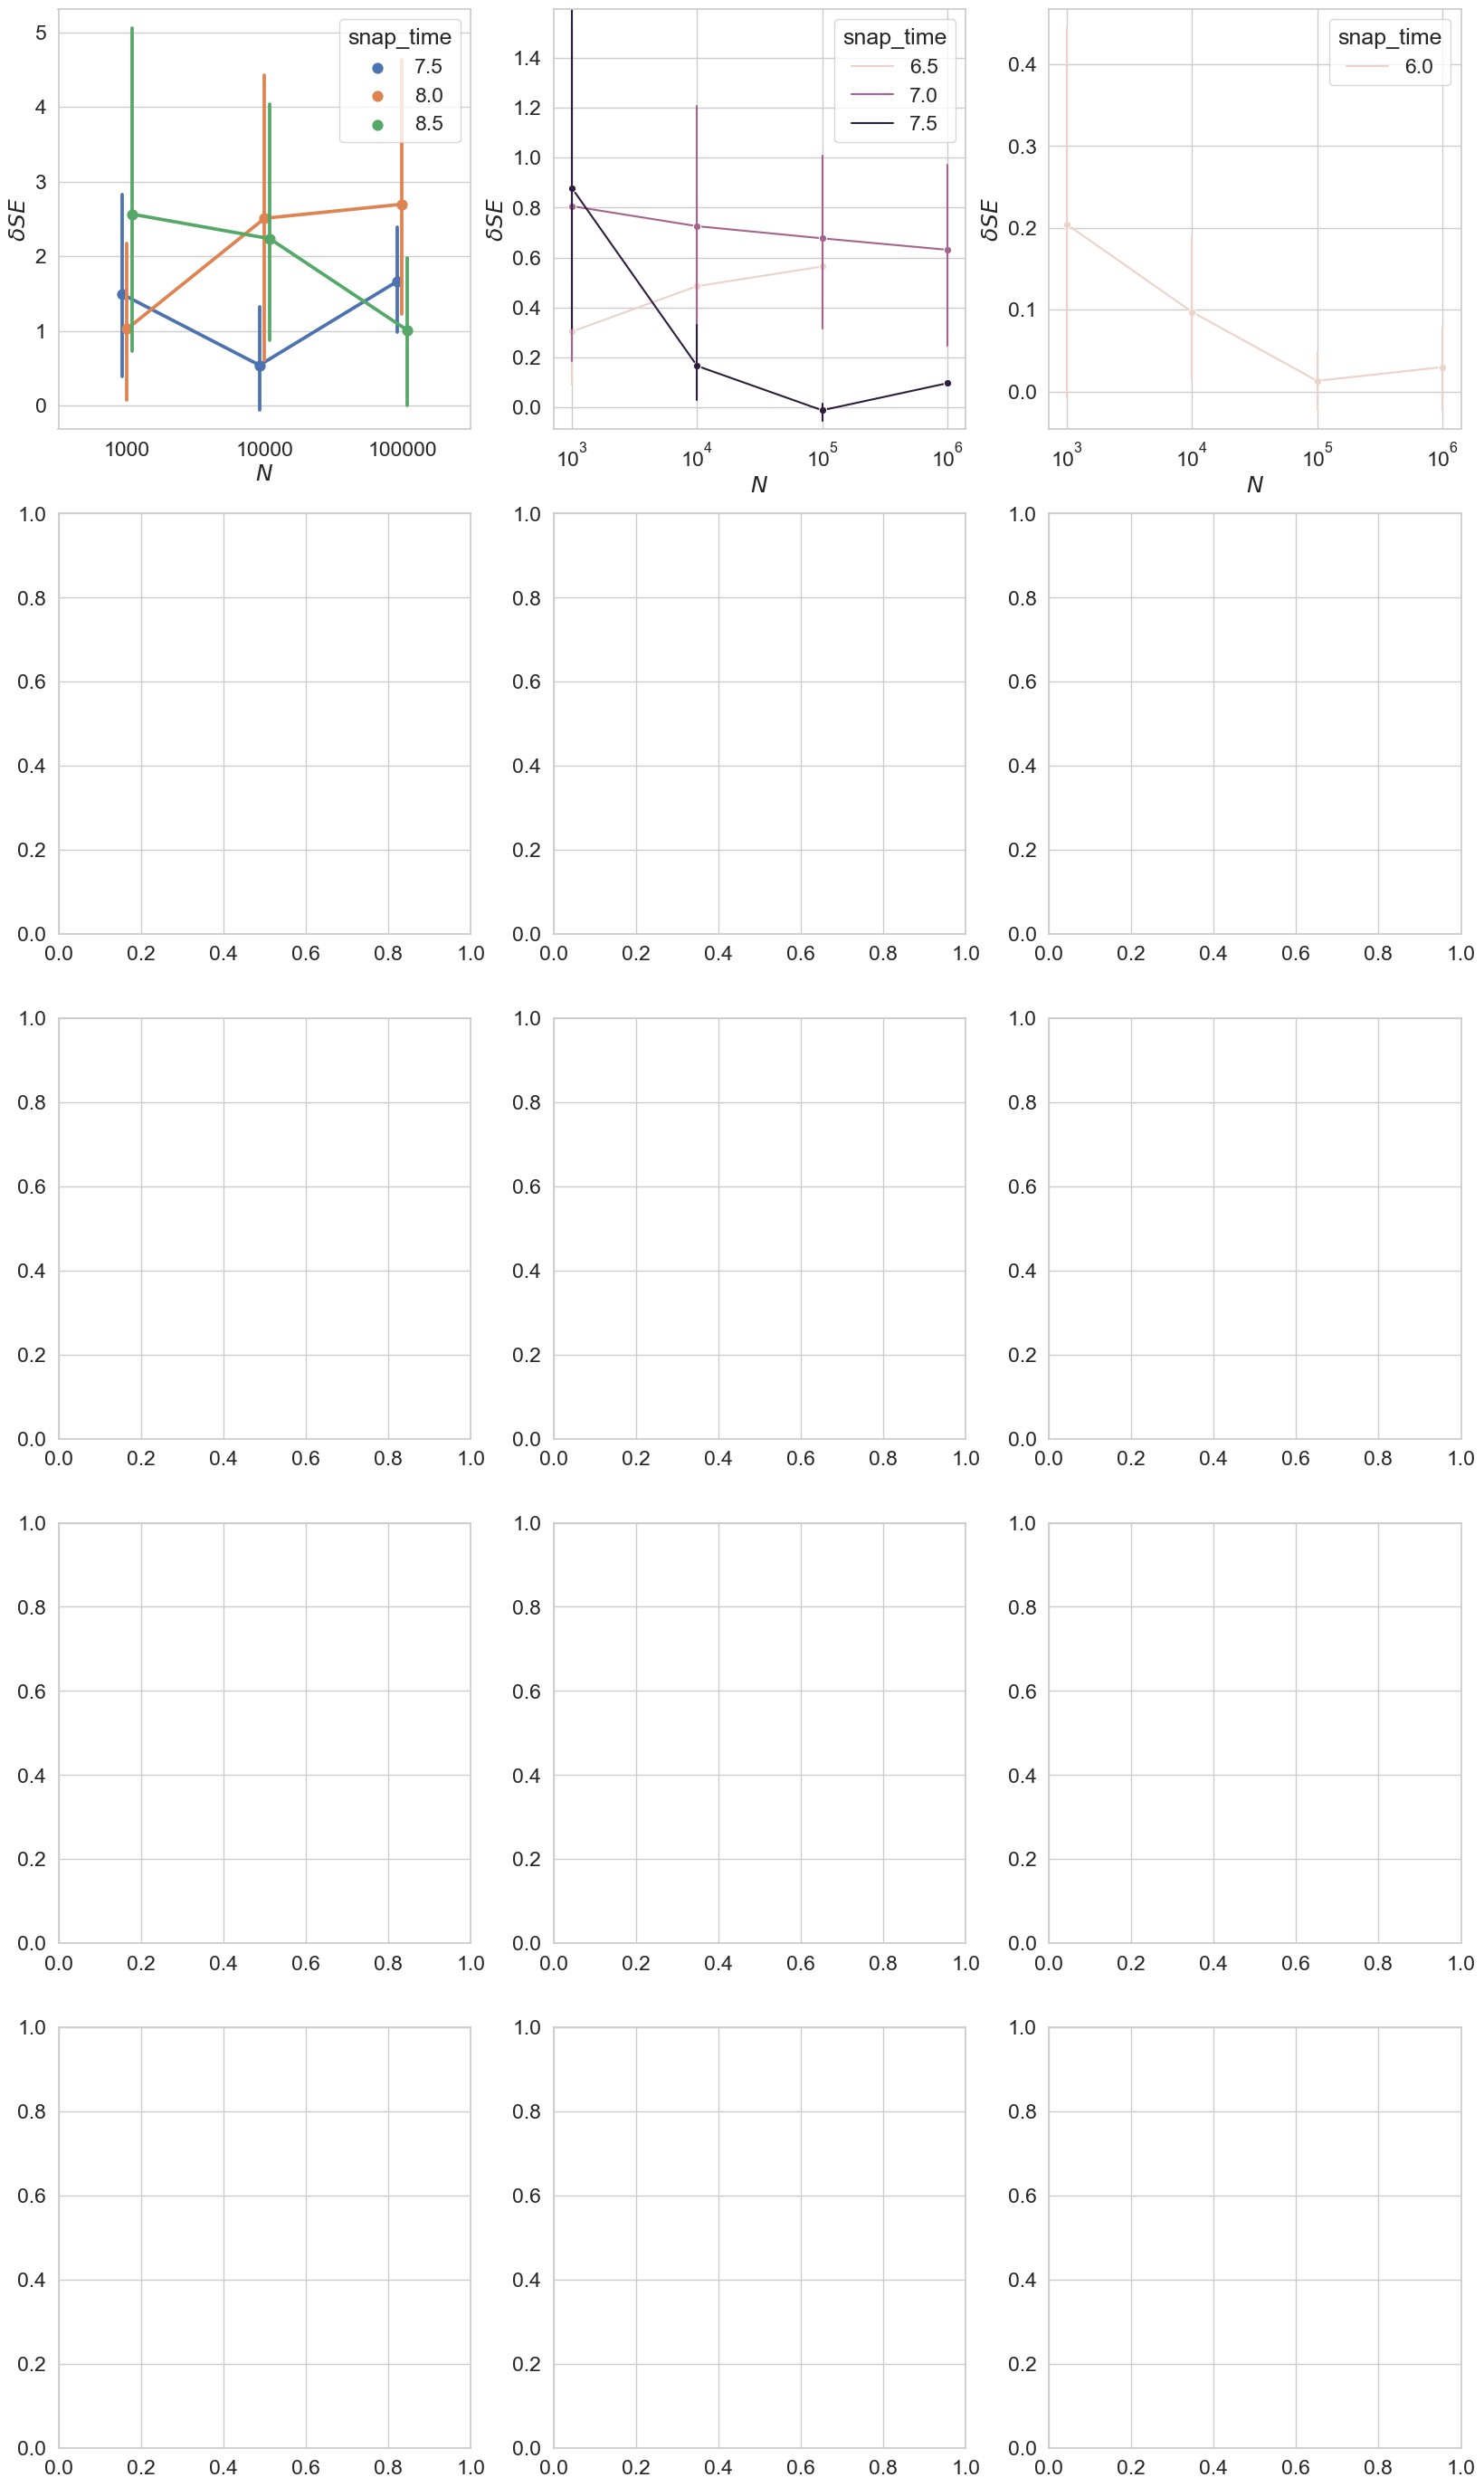

In [24]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

deltas=[0.01, 0.02, 0.03]
snap_times=[9, 10, 11,12, 13]
fig, axs = plt.subplots(5,len(deltas), figsize=(20, 35))
init="rnd"

dd=deltas[0]
delta_all = all_df[(np.abs(all_df["snap_time"]<=8.5)) & (np.abs(all_df["snap_time"]>=7.5)) & (all_df["init"]==init) & (np.abs(all_df["S"]-dd)< 1e-6) ]
sns.pointplot(data=delta_all, x=r"$N$", y=r"$\delta SE$", hue="snap_time", ax=axs[0][0], dodge=True)
#axs[0][0].set(xscale="log")

dd=deltas[1]
delta_all = all_df[(np.abs(all_df["snap_time"]<=7.5)) & (np.abs(all_df["snap_time"]>=6.5)) & (all_df["init"]==init) & (np.abs(all_df["S"]-dd)< 1e-6)  ]
sns.lineplot(data=delta_all, x=r"$N$", y=r"$\delta SE$",legend="full", hue="snap_time", ax=axs[0][1], estimator="mean", marker="o", hue_norm=LogNorm(), err_style="bars")
axs[0][1].set(xscale="log")

dd=deltas[2]
delta_all = all_df[(np.abs(all_df["snap_time"]<=6.)) & (np.abs(all_df["snap_time"]>=6.)) & (all_df["init"]==init) & (np.abs(all_df["S"]-dd)< 1e-6)  ]
sns.lineplot(data=delta_all, x=r"$N$", y=r"$\delta SE$",legend="full", ax=axs[0][2],hue="snap_time", estimator="mean", marker="o", hue_norm=LogNorm(), err_style="bars")
axs[0][2].set(xscale="log")



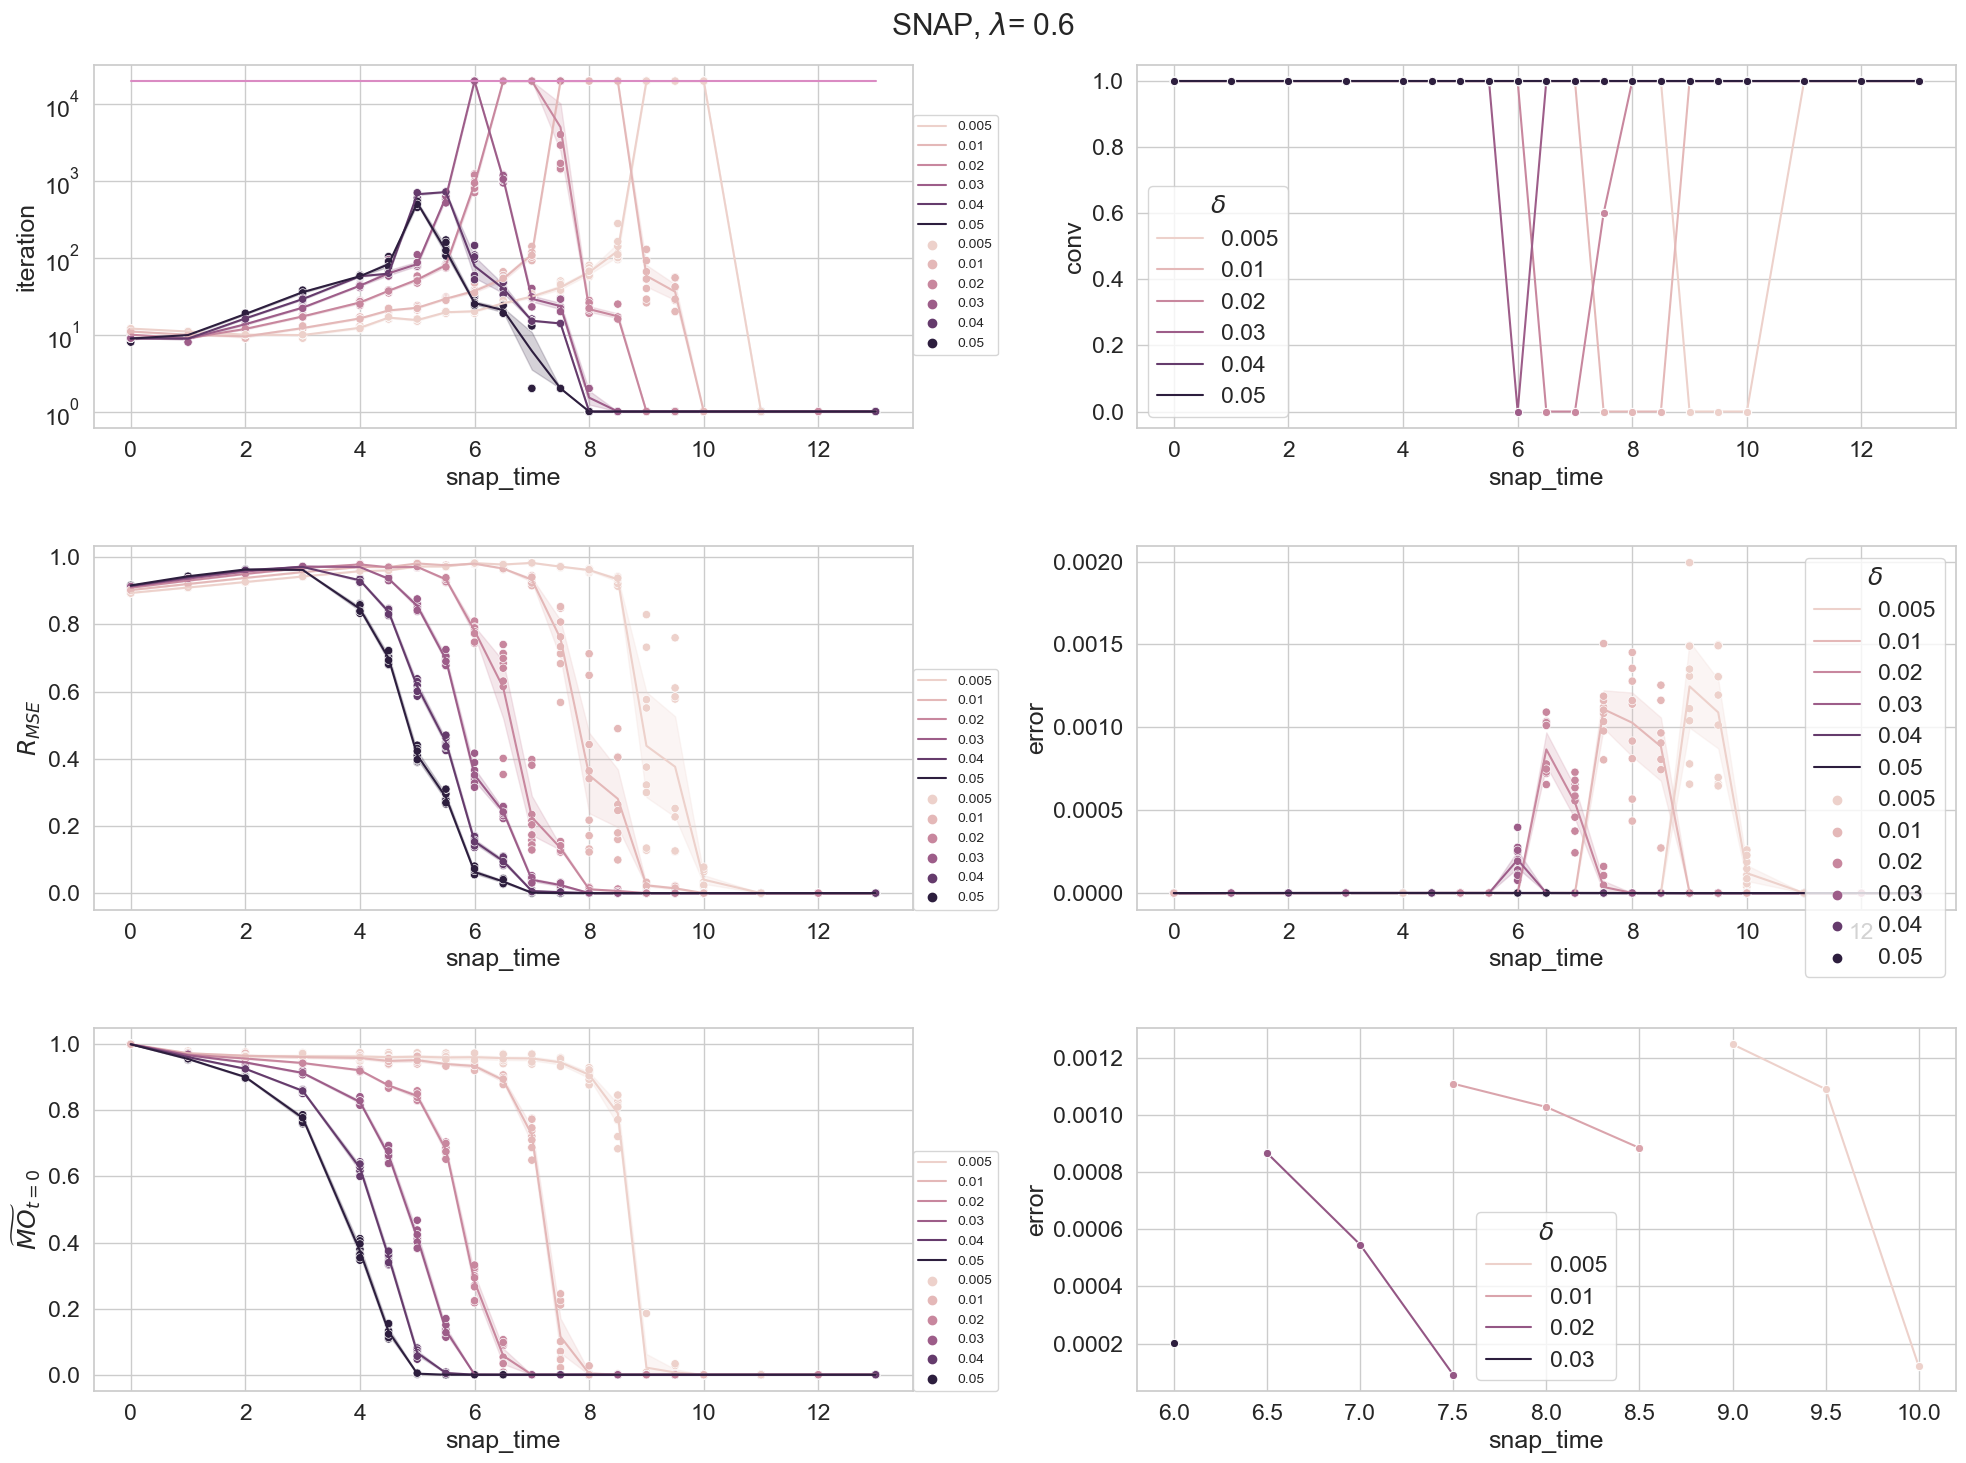

In [8]:
df_100K, df_100K_s, df_100K_l = load_df("n100K_09")
plot_df(df_100K_l)


In [9]:
df_100K_l.keys()

Index(['init', 'graph_type', '$N$', '$d$', '$\lambda$', 's_type', 'S',
       'o_type', 'M', 'iter_space', 'seed', 'tol', 'n_iter', 'obs_type',
       'snap_time', 'T_max', 'mask_type', '$\mu$', 'tol2', 'it_max', '$T$',
       '$f_S$', '$f_I$', '$T_O$', '$\Delta$', 'damping', 'error', 'iteration',
       'it_final', 'logL', '$O_{t=0}$', '$O_{t=0,RND}$', '$MO_{t=0}$',
       '$MO_{t=0,RND}$', '$\delta O_{t=0}$', '$\widetilde{O}_{t=0}$',
       '$\widetilde{MO}_{t=0}$', '$\widetilde{\delta O}_{t=0}$', '$O_{t=T}$',
       '$O_{t=T,RND}$', '$MO_{t=T}$', '$MO_{t=T,RND}$', '$\delta O_{t=T}$',
       '$\widetilde{O}_{t=T}$', '$\widetilde{MO}_{t=T}$',
       '$\widetilde{\delta O}_{t=T}$', 'SE', 'MSE', '$SE_{RND}$',
       '$MSE_{RND}$', '$\delta SE$', '$R_{SE}$', '$R_{MSE}$',
       '$\delta R_{SE}$', 'ConvChecks', '$\rho$', 'conv', '$\delta$'],
      dtype='object')

In [10]:
df_1K_l["S"]

0       0.050
1       0.050
2       0.005
3       0.005
4       0.030
        ...  
3325    0.010
3326    0.040
3327    0.040
3330    0.030
3331    0.030
Name: S, Length: 2400, dtype: float64

In [99]:
delta = 0.03
snap_time=6
init="rnd"
inst_1k = df_1K_l[(np.abs(df_1K_l["S"]-delta)< 1e-6) & (df_1K_l["snap_time"]==snap_time)  & (df_1K_l["init"]==init) ]
inst_10k = df_10K_l[(np.abs(df_10K_l["S"]-delta)< 1e-6) & (df_10K_l["snap_time"]==snap_time)  & (df_10K_l["init"]==init) ]
inst_100k = df_100K_l[(np.abs(df_100K_l["S"]-delta)< 1e-6) & (df_100K_l["snap_time"]==snap_time)  & (df_100K_l["init"]==init) ]

In [ ]:
y

In [102]:
y2

[array(0.00110948, dtype=float32),
 array(0.00092116, dtype=float32),
 array(0.00190797, dtype=float32),
 array(0.00305066, dtype=float32),
 array(0.0051718, dtype=float32),
 array(0.00286954, dtype=float32),
 array(0.00794914, dtype=float32),
 array(0.00880359, dtype=float32),
 array(0.00821452, dtype=float32),
 array(0.00395254, dtype=float32),
 array(0.00678805, dtype=float32),
 array(0.00900651, dtype=float32),
 array(0.00822977, dtype=float32),
 array(0.0055092, dtype=float32),
 array(0.00340879, dtype=float32),
 array(0.00935816, dtype=float32),
 array(0.00844663, dtype=float32),
 array(0.00714601, dtype=float32),
 array(0.00307658, dtype=float32),
 array(0.00874062, dtype=float32),
 array(0.00376484, dtype=float32),
 array(0.00204142, dtype=float32),
 array(0.00270751, dtype=float32),
 array(0.00320886, dtype=float32),
 array(0.00142098, dtype=float32),
 array(0.00258643, dtype=float32),
 array(0.00298811, dtype=float32),
 array(0.00211074, dtype=float32),
 array(0.00248022, dty

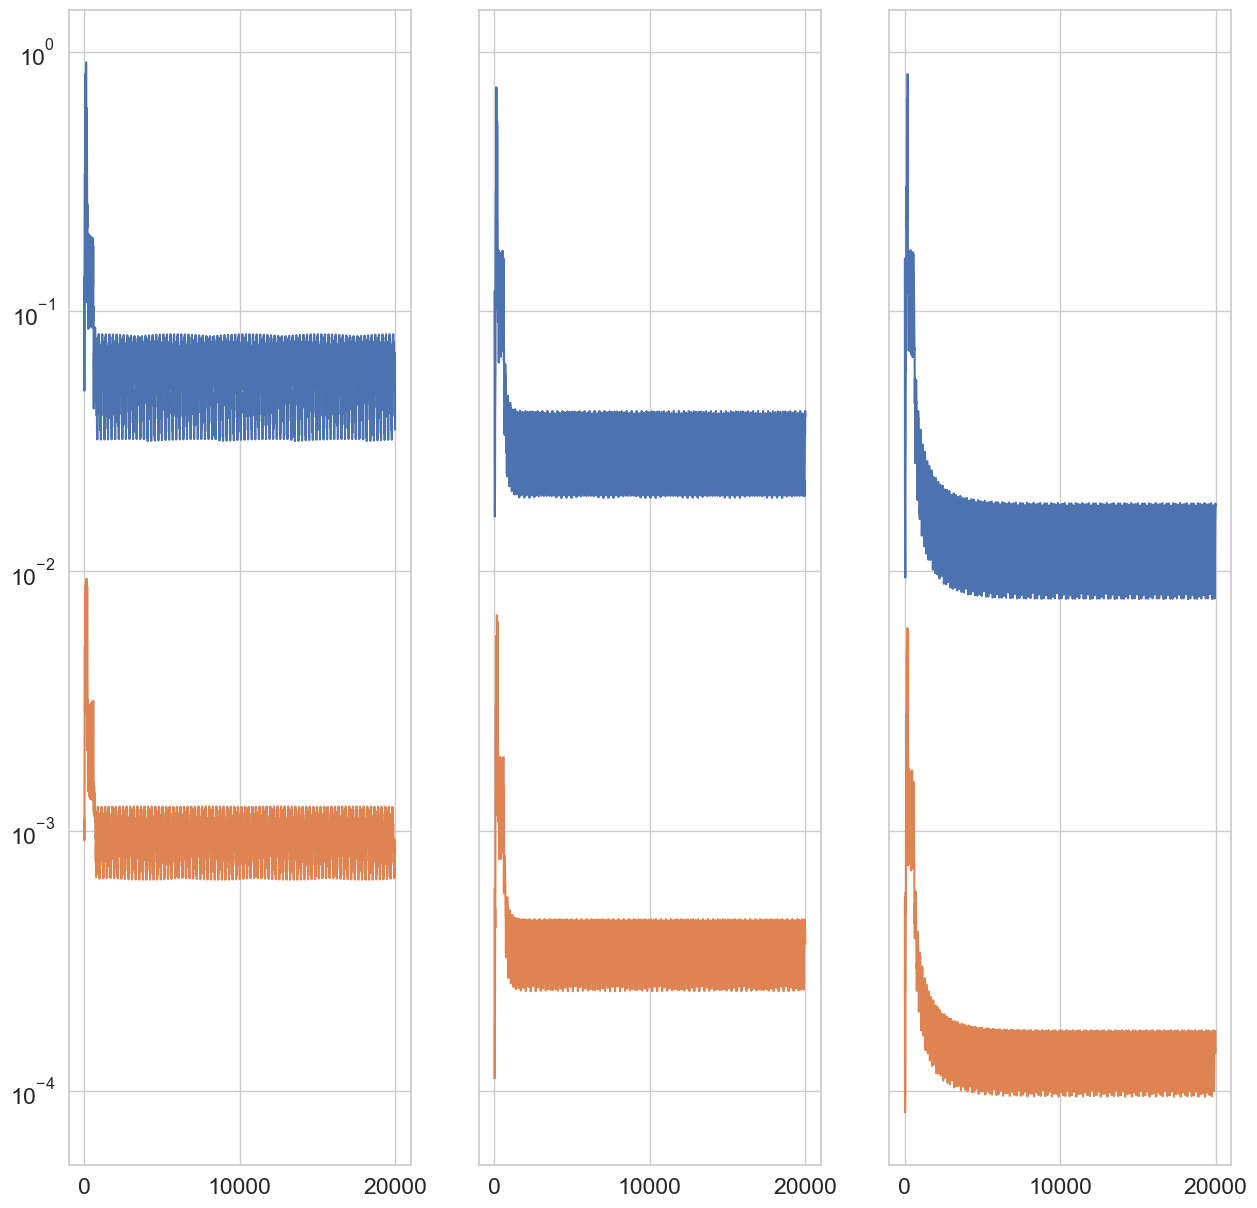

In [120]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,3, figsize=(15,15), sharey="row")
inst = 0
vals = inst_1k.iloc[inst]["ConvChecks"]
x = [xx[0] for xx in vals]
y1 = [xx[1] for xx in vals]
y2 = [xx[2] for xx in vals]
axs[0].plot(x, y1, x, y2)

vals = inst_10k.iloc[inst]["ConvChecks"]
x = [xx[0] for xx in vals]
y1 = [xx[1] for xx in vals]
y2 = [xx[2] for xx in vals]
axs[1].plot(x, y1, x, y2)


vals = inst_100k.iloc[inst]["ConvChecks"]
x = [xx[0] for xx in vals]
y1 = [xx[1] for xx in vals]
y2 = [xx[2] for xx in vals]
axs[2].plot(x, y1, x, y2)

plt.yscale("log")

In [ ]:
inst_1k = df_1K_l[(df_1K_l["S"]==delta) & (df_1K_l["snap_time"]==snap_time) ]

In [82]:
pos=1000

df_100K_l.iloc[pos]["error"]

3.9985712518841865e-09

In [83]:
df_100K_l.iloc[pos]["ConvChecks"]

[[9, array(5.9604645e-07, dtype=float32), array(3.9985713e-09, dtype=float32)]]

In [19]:
miss_values(df_100K)

delta:0.001, snap_time:0, missing seed:1      
delta:0.001, snap_time:0, missing seed:2      
delta:0.001, snap_time:0, missing seed:3      
delta:0.001, snap_time:0, missing seed:4      
delta:0.001, snap_time:0, missing seed:5      
delta:0.001, snap_time:0, missing seed:6      
delta:0.001, snap_time:0, missing seed:7      
delta:0.001, snap_time:0, missing seed:8      
delta:0.001, snap_time:0, missing seed:9      
delta:0.001, snap_time:0, missing seed:10      
delta:0.001, snap_time:1, missing seed:1      
delta:0.001, snap_time:1, missing seed:2      
delta:0.001, snap_time:1, missing seed:3      
delta:0.001, snap_time:1, missing seed:4      
delta:0.001, snap_time:1, missing seed:5      
delta:0.001, snap_time:1, missing seed:6      
delta:0.001, snap_time:1, missing seed:7      
delta:0.001, snap_time:1, missing seed:8      
delta:0.001, snap_time:1, missing seed:9      
delta:0.001, snap_time:1, missing seed:10      
delta:0.001, snap_time:2, missing seed:1      
delta:0.001

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [18., 18., 18., 18., 20., 16., 18., 18., 20., 20., 20., 20., 20.,
        20., 18., 18., 20., 18., 18., 20.],
       [20., 20., 18., 18., 18., 18., 18., 18., 18., 20., 20., 18., 20.,
        16., 20., 18., 20., 18., 18., 20.],
       [20., 20., 18., 18., 20., 18., 18., 20., 20., 18., 18., 20., 18.,
        20., 20., 18., 18., 18., 18., 20.],
       [18., 20., 20., 18., 20., 20., 18., 20., 20., 20., 20., 20., 20.,
        20., 20., 20., 18., 18., 20., 18.],
       [20., 18., 20., 18., 18., 18., 18., 18., 20., 20., 20., 20., 20.,
        20., 20., 18., 20., 20., 20., 18.],
       [18., 18., 18., 20., 18., 18., 18., 16., 20., 20., 20., 20., 20.,
        20., 20., 18., 20., 20., 20., 18.]])

Text(0.5, 1.0, '10K')

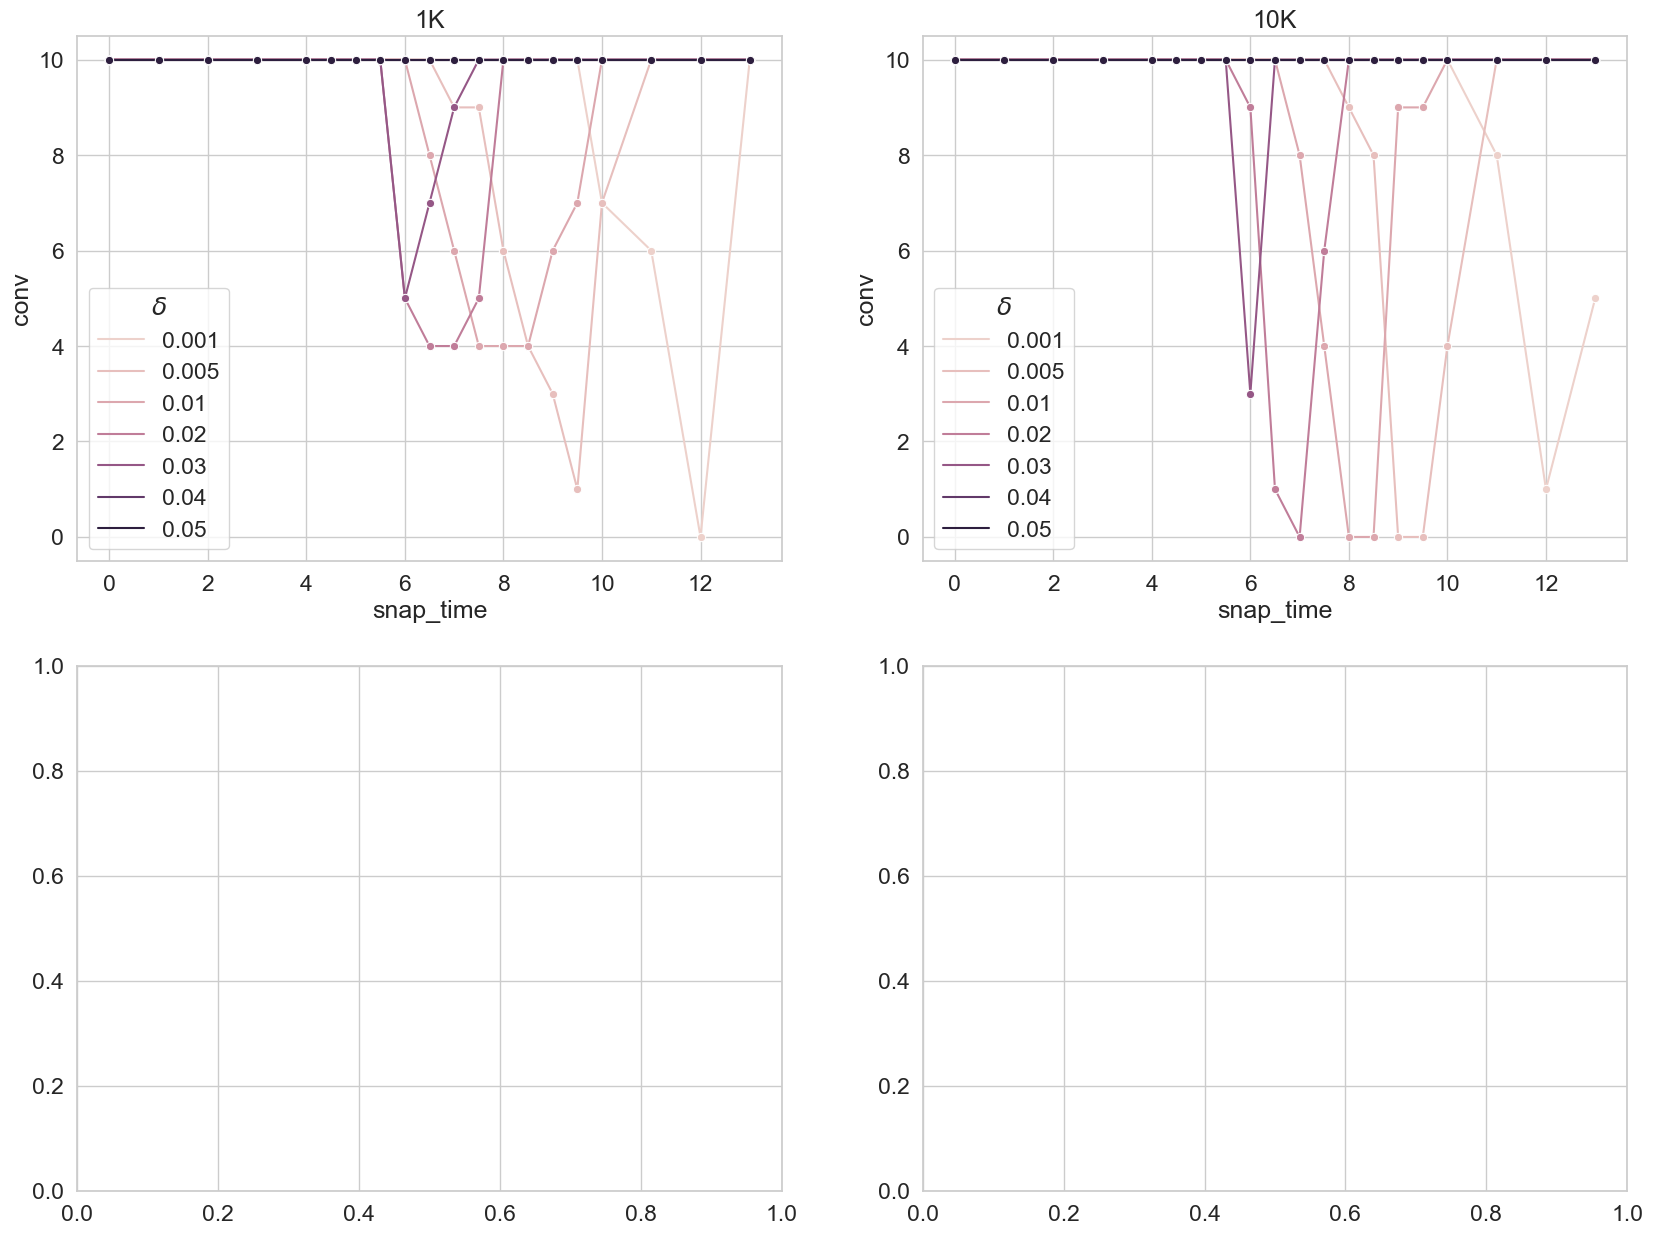

In [88]:
fig,axs = plt.subplots(2,2, figsize=(20,15))

data_frame=df_1K
sns.lineplot(data=data_frame[(data_frame["init"]==init_s)], x=r"snap_time", hue=del_s, y="conv",legend="full", ax=axs[0][0], estimator="sum", errorbar=None, marker="o")

data_frame=df_10K
sns.lineplot(data=data_frame[(data_frame["init"]==init_s)], x=r"snap_time", hue=del_s, y="conv",legend="full", ax=axs[0][1], estimator="sum", errorbar=None, marker="o")
axs[0][0].set_title("1K")
axs[0][1].set_title("10K")

In [ ]:
df_10K["conv"] = df_10K["iteration"]<20000

In [ ]:
df_10K

init graph_type    $N$  $d$  $\lambda$ s_type     S o_type    M  \
0     rnd        rrg  10000    3        0.6  delta  0.09    rho  1.0   
1     inf        rrg  10000    3        0.6  delta  0.09    rho  1.0   
2     rnd        rrg  10000    3        0.6  delta  0.03    rho  1.0   
3     inf        rrg  10000    3        0.6  delta  0.03    rho  1.0   
4     rnd        rrg  10000    3        0.6  delta  0.01    rho  1.0   
...   ...        ...    ...  ...        ...    ...   ...    ...  ...   
7141  inf        rrg  10000    3        0.6  delta  0.10    rho  1.0   
7142  rnd        rrg  10000    3        0.6  delta  0.10    rho  1.0   
7143  inf        rrg  10000    3        0.6  delta  0.10    rho  1.0   
7144  rnd        rrg  10000    3        0.6  delta  0.03    rho  1.0   
7145  inf        rrg  10000    3        0.6  delta  0.03    rho  1.0   

      iter_space  ...  $SE_{RND}$  $MSE_{RND}$  $\delta SE$      $R_{SE}$  \
0            100  ...    3.229187     3.207420     0.021765  4.720977e-07   
1            100  ...    3.229187     3.207359     0.021826  4.396335e-07   
2            100  ...    4.982063     4.981996    -0.016257  4.101088e-02   
3            100  ...    4.982578     4.984563    -0.018548  4.099716e-02   
4            100  ...    6.319099     6.347285    -0.135617  4.889857e-02   
...          ...  ...         ...          ...          ...           ...   
7141         100  ...    2.989298     2.979262     0.003381  8.528874e-01   
7142         100  ...    3.025042     3.035940    -0.010898  7.037987e-08   
7143         100  ...    3.025042     3.035851    -0.010809  8.390107e-08   
7144         100  ...    4.859014     4.914307    -0.055309  3.331924e-06   
7145         100  ...    4.859018     4.914478    -0.055478  3.729901e-06   

         $R_{MSE}$  $\delta R_{SE}$  \
0     4.296707e-09     4.678010e-07   
1     4.032432e-09     4.356011e-07   
2     3.773480e-02     3.276076e-03   
3     3.765807e-02     3.339093e-03   
4     3.175588e-02     1.714269e-02   
...            ...              ...   
7141  8.535268e-01    -6.393817e-04   
7142  6.212901e-10     6.975858e-08   
7143  1.418646e-09     8.248242e-08   
7144  9.832563e-09     3.322091e-06   
7145  1.210667e-08     3.717794e-06   

                                             ConvChecks  $\rho$  $\delta$  \
0                   [[1, 1.6040867e-06, 1.6769134e-07]]     1.0      0.09   
1     [[10, 0.002485109, 4.130451e-05], [13, 4.87626...     1.0      0.09   
2     [[10, 0.006028697, 4.836983e-05], [20, 0.00010...     1.0      0.03   
3     [[10, 0.07238375, 0.00072823005], [20, 0.00042...     1.0      0.03   
4     [[10, 0.00515889, 5.4020802e-05], [20, 0.00022...     1.0      0.01   
...                                                 ...     ...       ...   
7141  [[10, 0.042182237, 2.555856e-05], [17, 0.00387...     1.0      0.10   
7142                 [[1, 3.978377e-06, 3.9502402e-07]]     1.0      0.10   
7143  [[10, 0.0012945868, 2.017744e-05], [13, 1.0680...     1.0      0.10   
7144                [[1, 2.7565984e-06, 2.4699995e-07]]     1.0      0.03   
7145  [[10, 0.019590218, 0.00048112933], [17, 2.2373...     1.0      0.03   

      conv  
0     True  
1     True  
2     True  
3     True  
4     True  
...    ...  
7141  True  
7142  True  
7143  True  
7144  True  
7145  True  

[7146 rows x 58 columns]

In [24]:
miss_values(df_10K)

missing values delta:0.005  0.0 0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0 5.5 6.0 6.5 7.0 7.5 8.0 8.5 9.0 9.5 10.0 10.5 11.0 11.5 12.0 12.5 13.0 13.5 14.0 14.5 15.0 15.5 16.0 16.5 17.0
all values delta:0.01 
all values delta:0.02 
all values delta:0.03 
all values delta:0.04 
all values delta:0.05 


array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [12., 14., 12., 12.,  8., 16., 12., 12., 12., 12., 10., 14., 16.,
        16., 18., 20., 20., 20., 20., 22., 20., 20., 20., 20., 20., 20.,
        20., 18., 18., 16., 20., 18., 20., 20., 18.],
       [12.,  2., 16., 10., 16., 16., 16., 14., 14., 18., 12., 16., 14.,
        14., 18., 20., 16., 18., 20., 20., 20., 20., 16., 16., 12., 18.,
        16., 18., 20., 18., 20., 20., 20., 18., 18.],
       [18., 20., 14., 20., 20., 16., 12., 16., 18., 14., 16., 18., 20.,
        18., 20., 20., 18., 18., 18., 16., 20., 20., 16., 18., 18., 20.,
        20., 20., 20., 20., 20., 18., 18., 20., 18.],
       [ 8.,  4.,  6.,  8.,  6.,  6., 10.,  8., 10., 10., 10.,  6.,  6.,
        10., 16., 12.,  6.,  8., 10.,  8., 12., 10.,  8., 14., 12., 18.,
        14., 14., 14., 14., 18., 14., 20., 20., 12.],


# N=50K

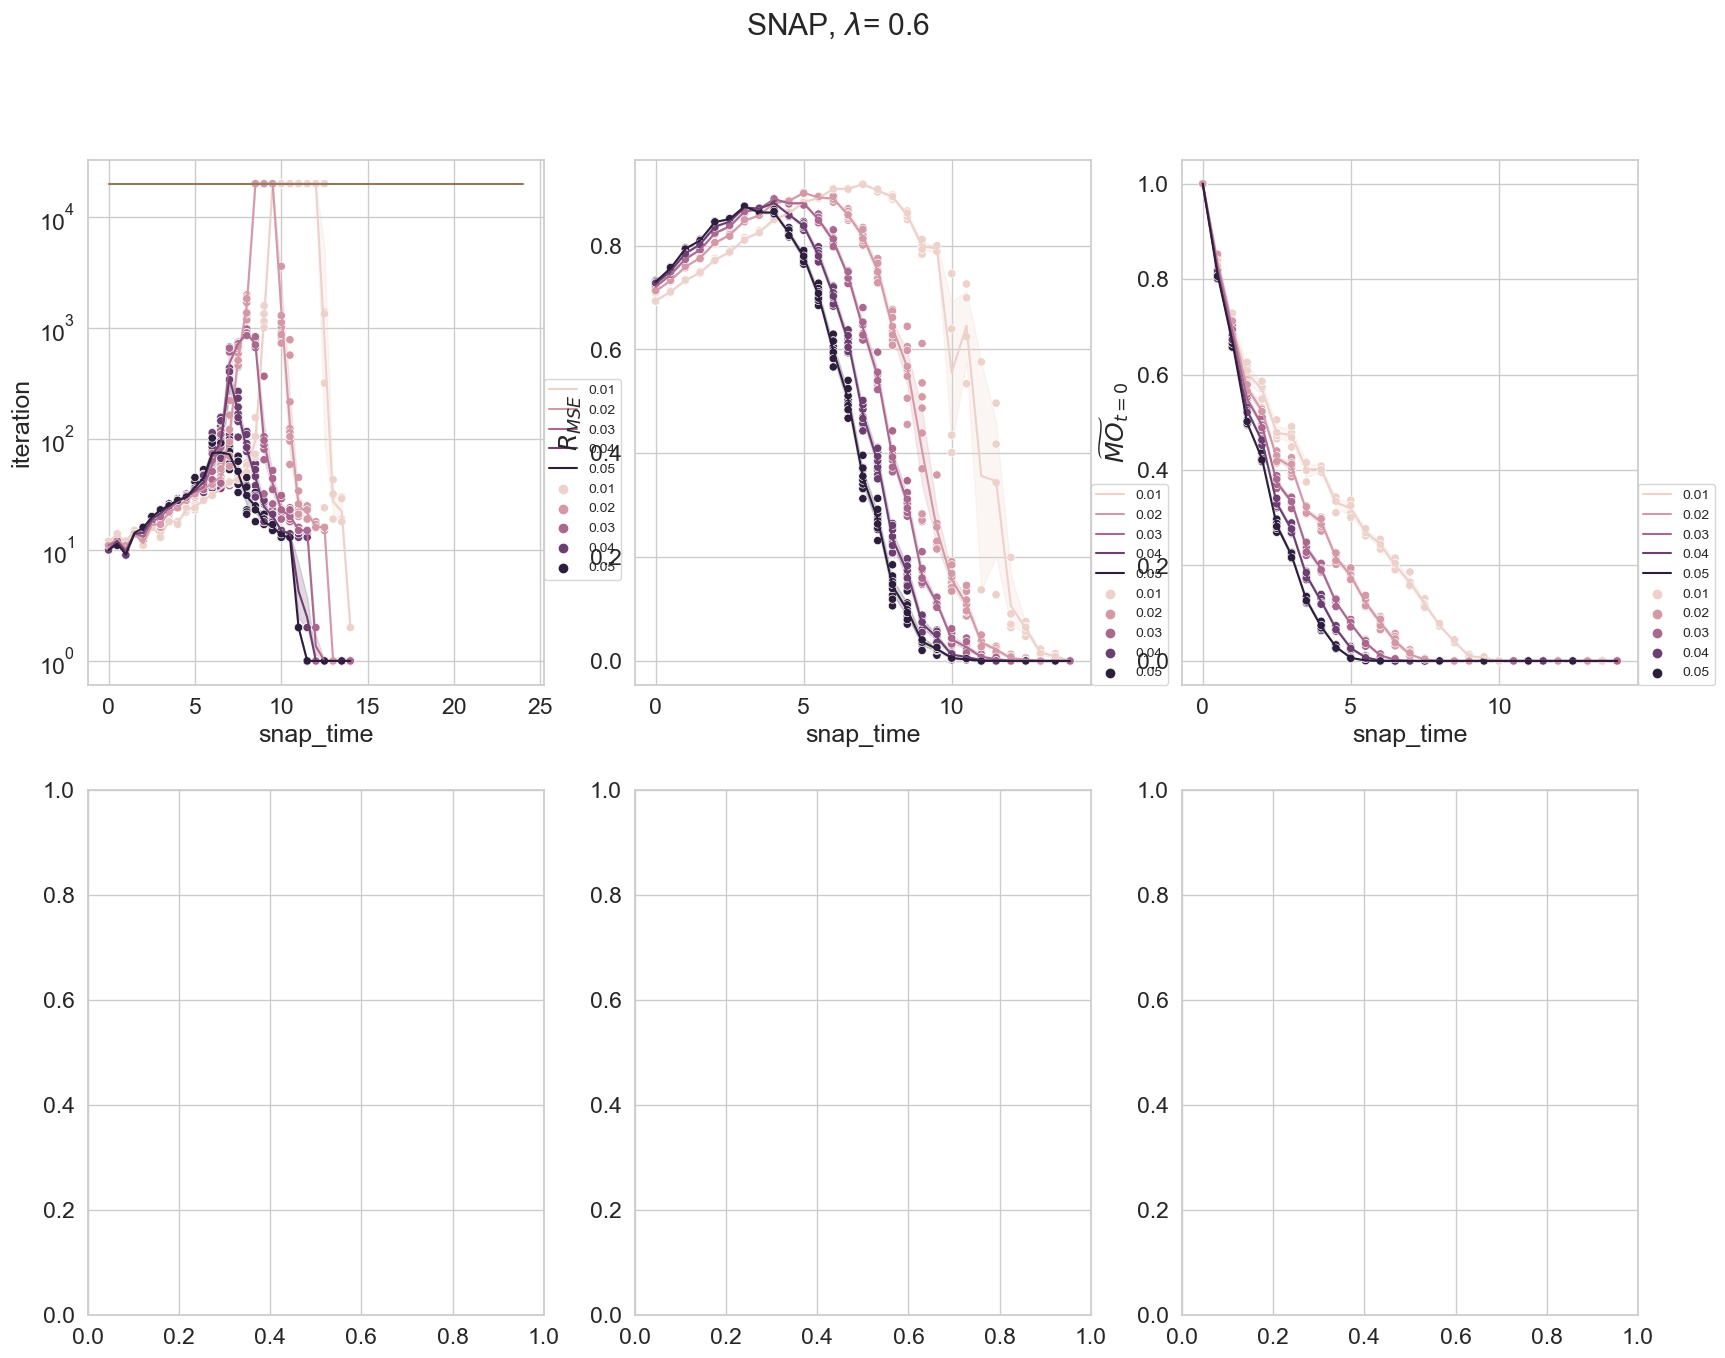

In [19]:
df_50K, df_50K_s, df_50K_l = load_df("n50K")
plot_df(df_50K)

In [21]:
miss_values(df_50K)

missing values delta:0.005  0.0 0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0 5.5 6.0 6.5 7.0 7.5 8.0 8.5 9.0 9.5 10.0 10.5 11.0 11.5 12.0 12.5 13.0 13.5 14.0 14.5 15.0 15.5 16.0 16.5 17.0
missing values delta:0.01  14.5 15.0 15.5 16.0 16.5 17.0
missing values delta:0.02  14.5 15.0 15.5 16.0 16.5 17.0
missing values delta:0.03  14.5 15.0 15.5 16.0 16.5 17.0
missing values delta:0.04  14.5 15.0 15.5 16.0 16.5 17.0
missing values delta:0.05  14.5 15.0 15.5 16.0 16.5 17.0


array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [10., 10., 10., 10.,  8., 10., 10.,  8.,  6.,  8., 10., 10., 10.,
        10., 10., 10., 10., 10., 10.,  4.,  8.,  8.,  4.,  8.,  8., 10.,
        10., 10.,  8.,  0.,  0.,  0.,  0.,  0.,  0.],
       [16., 20., 18., 18., 14., 18., 20., 18., 16., 20., 16., 20., 18.,
        18., 20., 20., 20., 20., 20., 14., 20., 20., 18., 16., 16., 18.,
        20., 18., 16.,  0.,  0.,  0.,  0.,  0.,  0.],
       [16., 16., 12., 14., 18., 20., 16., 16., 14., 18., 20., 20., 18.,
        18., 20., 20., 20., 20., 20., 18., 20., 20., 18., 20., 18., 16.,
        18., 20., 20.,  0.,  0.,  0.,  0.,  0.,  0.],
       [18., 20., 18., 18., 18., 18., 20., 20., 18., 12., 18., 14., 18.,
        20., 20., 20., 18., 16., 16., 18., 18., 16., 20., 18., 18., 18.,
        20., 18., 18.,  0.,  0.,  0.,  0.,  0.,  0.],


# N=5000

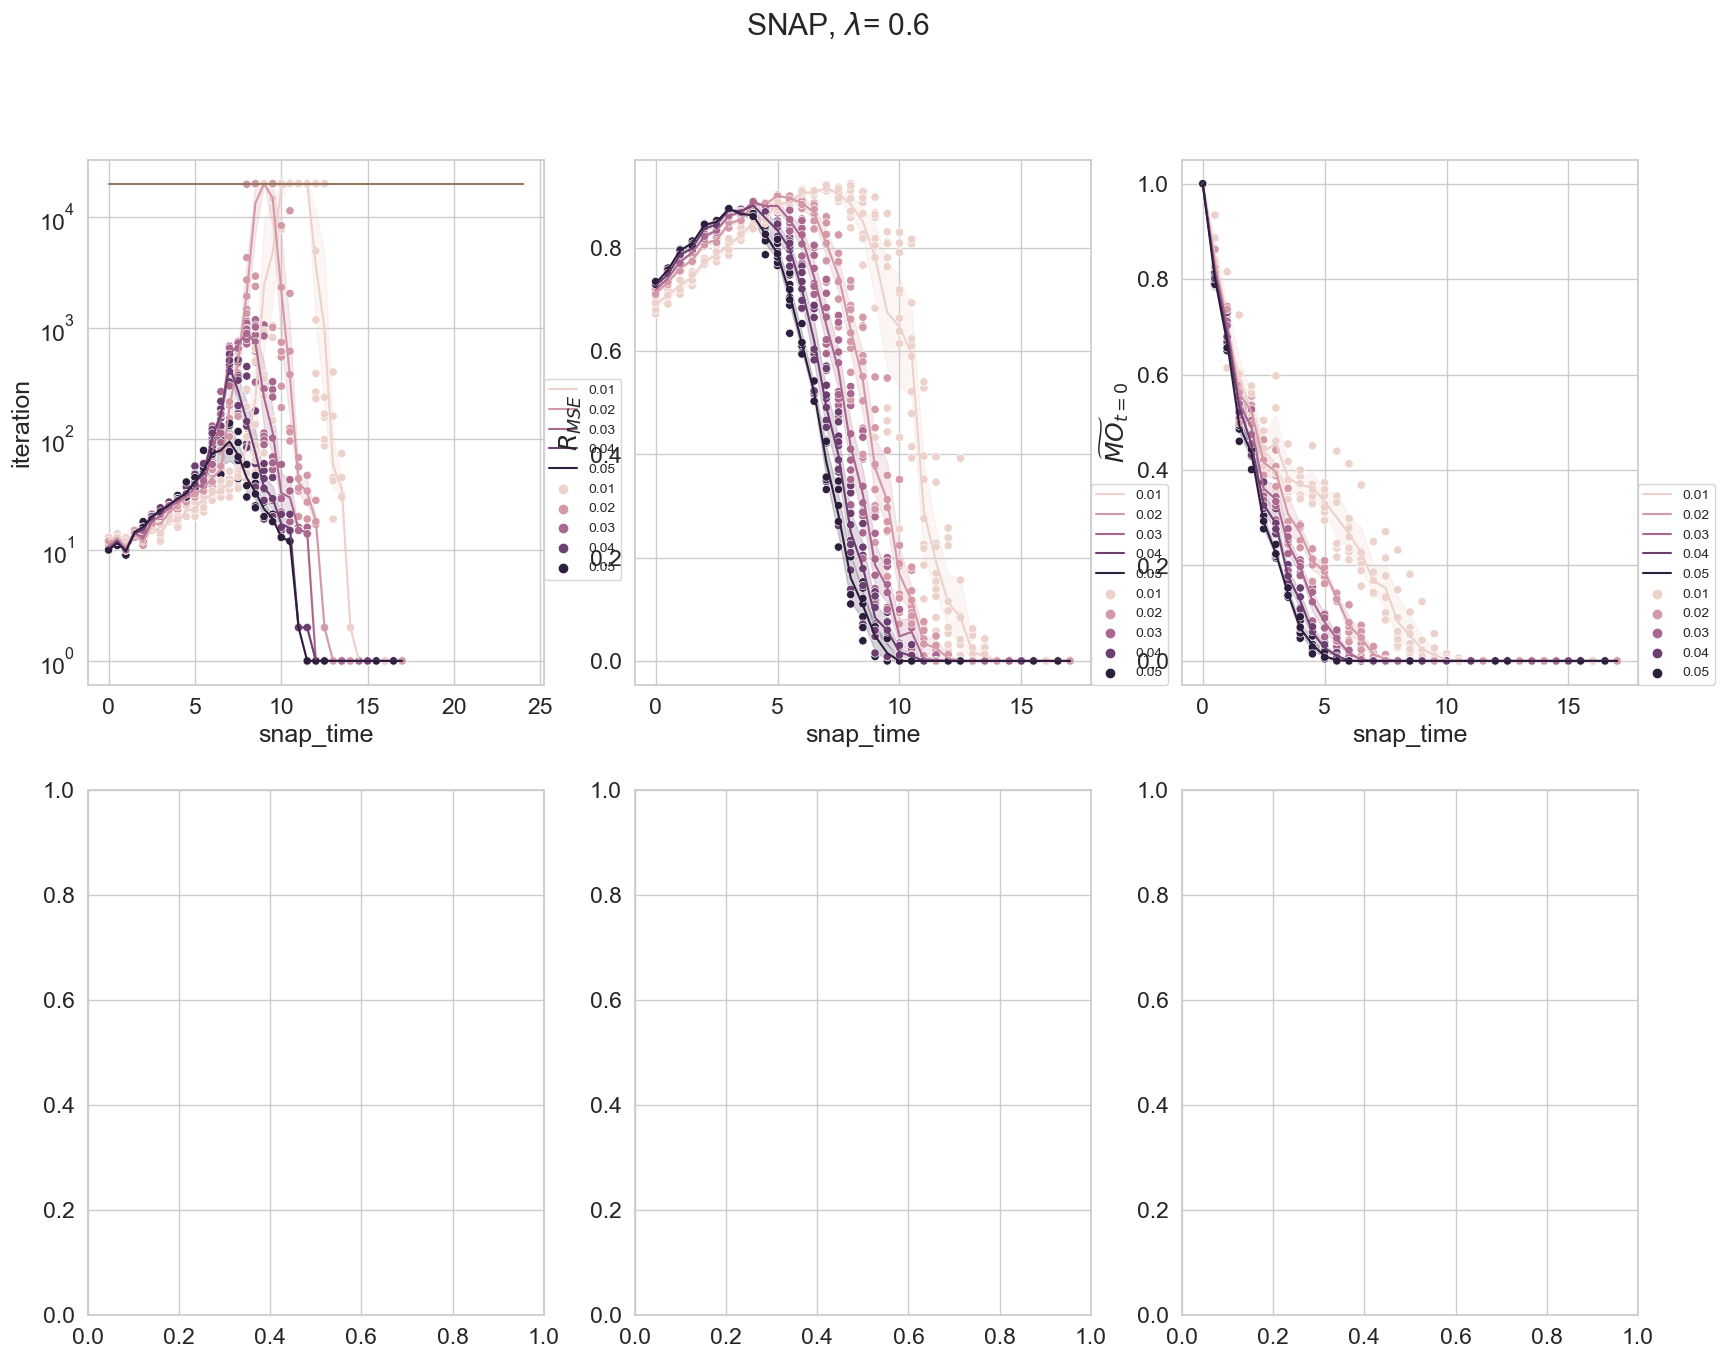

In [25]:
df_5K, df_5K_s, df_5K_l = load_df("n5000")
plot_df(df_5K_l)

In [26]:
miss_values(df_5K)

all values delta:0.005 
all values delta:0.01 
all values delta:0.02 
all values delta:0.03 
all values delta:0.04 
all values delta:0.05 


array([[18., 18., 14., 12., 16., 16., 16., 14., 14., 10., 14., 12., 16.,
        14., 18., 14., 20., 12., 16., 16., 18., 16., 20., 20., 20., 20.,
        20., 20., 20., 20., 18., 10., 14., 10., 12.],
       [16., 14., 12., 16., 10., 12., 14., 12., 14., 14., 14., 16., 20.,
        14., 14., 14., 18., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
        18., 18., 18., 18., 14., 10., 16., 14.,  6.],
       [14., 14., 16., 14., 10.,  8., 16., 10., 10., 12., 12.,  8., 16.,
        14., 16., 18., 20., 20., 20., 20., 20., 18., 18., 12., 16., 12.,
        18., 10.,  8., 14.,  8., 12., 12.,  8., 14.],
       [12., 10., 10., 12.,  8., 14., 10., 14., 10., 10., 10., 16., 14.,
        18., 20., 20., 20., 20., 18., 16.,  8.,  6.,  6., 14.,  6., 10.,
        14., 10.,  6., 10., 10., 10., 10., 14., 10.],
       [14., 12., 10.,  8.,  8., 12., 10., 10., 12.,  8., 12., 14., 14.,
        14., 20., 20., 20., 12., 16., 10.,  6., 14., 16.,  8., 10., 12.,
         8., 12., 12., 10., 16., 12.,  8.,  8.,  8.],


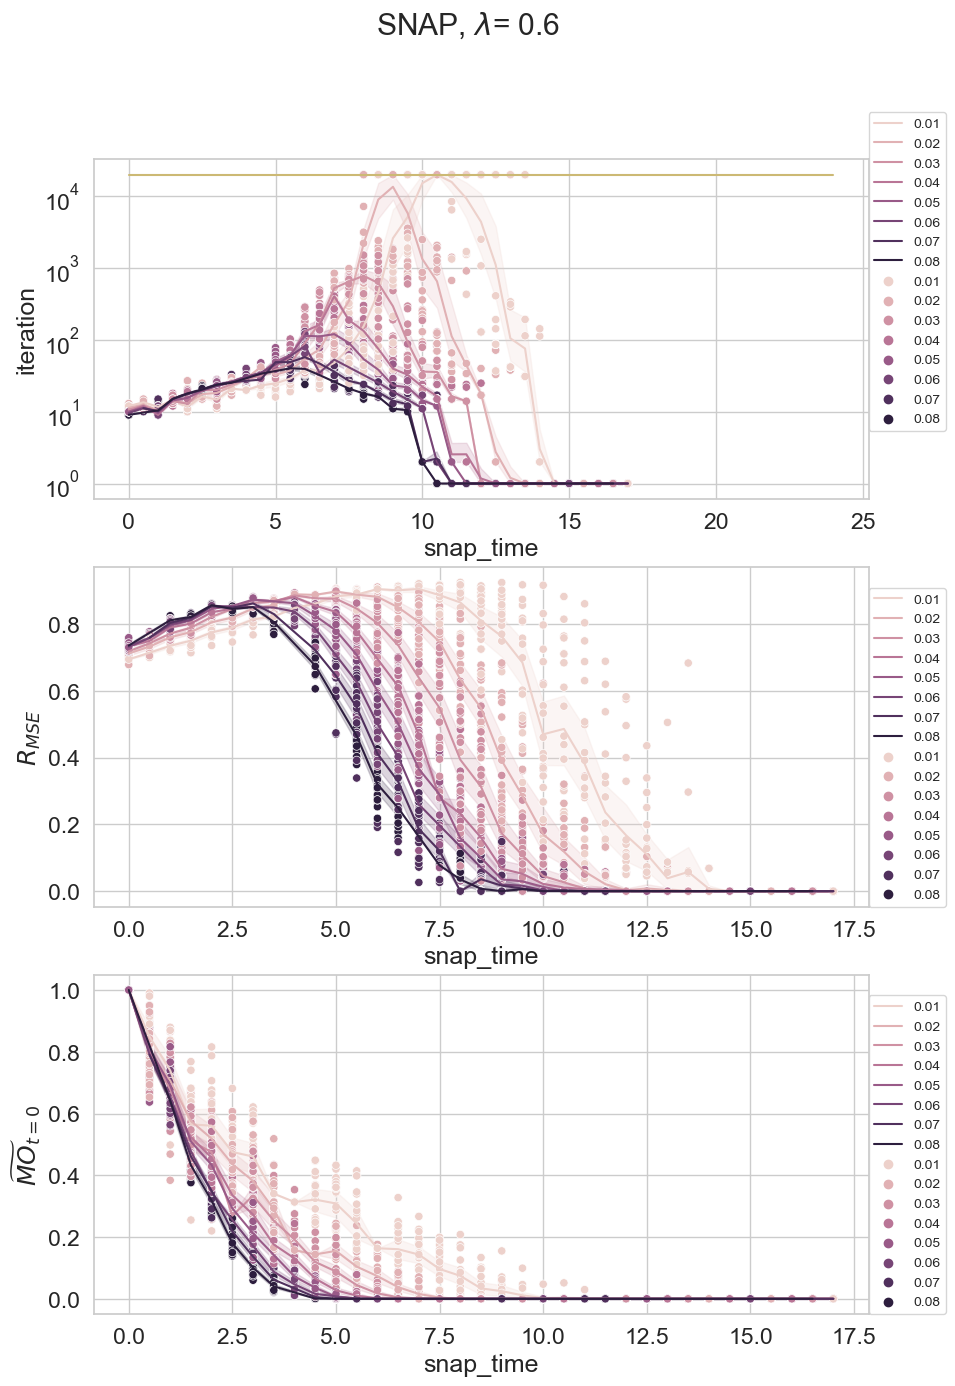

In [189]:
df_1K, df_1K_s, df_1K_l = load_df("n1000")
plot_df(df_1K_l)

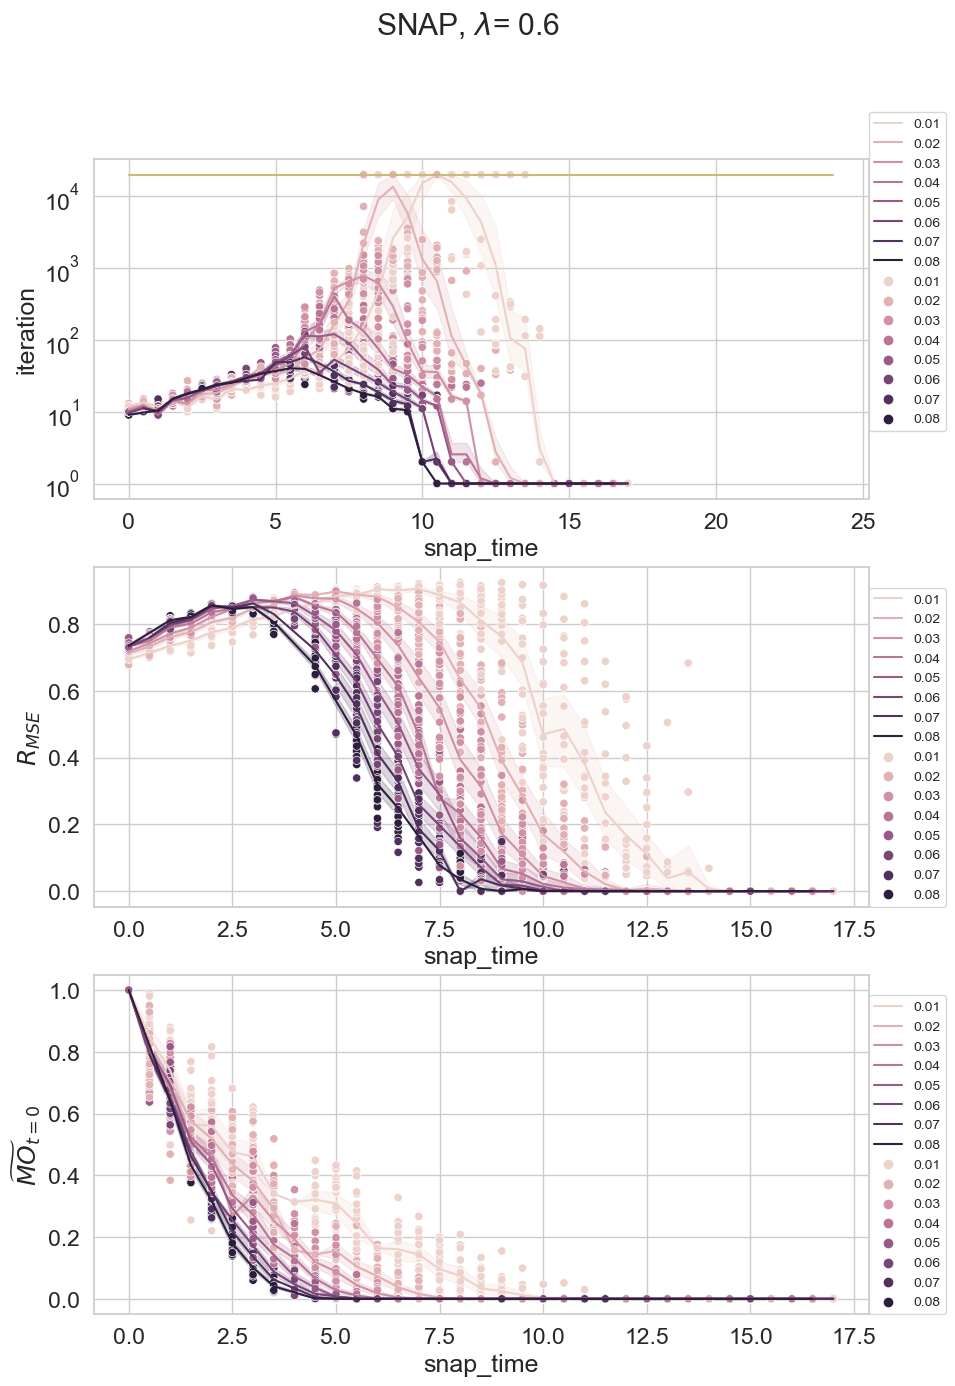

In [190]:
plot_df(df_1000_l)

In [156]:
miss_values(data_frame)

delta:0.001, snap_time:9.0
delta:0.001  9.0
delta:0.003 
delta:0.005 
delta:0.007 
delta:0.009 
delta:0.01 
delta:0.02 
delta:0.03 
delta:0.04 
delta:0.05, snap_time:3.5
delta:0.05  3.5
delta:0.06, snap_time:3.0
delta:0.06, snap_time:5.0
delta:0.06, snap_time:7.5
delta:0.06, snap_time:8.0
delta:0.06  3.0 5.0 7.5 8.0
delta:0.07, snap_time:0.0
delta:0.07, snap_time:4.0
delta:0.07  0.0 4.0
delta:0.08, snap_time:0.5
delta:0.08, snap_time:4.0
delta:0.08, snap_time:5.0
delta:0.08, snap_time:7.0
delta:0.08, snap_time:17.0
delta:0.08  0.5 4.0 5.0 7.0 17.0


In [135]:
file_name = "n2000.xz"
with lzma.open(load_dir + file_name, "rb") as f:
    data_frame = pickle.load(f)

mo0t_s = r"$\widetilde{MO}_{t=0}$"
Rmse_s = r"$R_{MSE}$"
data_frame = data_frame[(data_frame["o_type"]=="rho") & (data_frame["s_type"]=="delta")]
data_frame[r_s] = data_frame["M"]
data_frame[del_s] = data_frame["S"]

In [137]:
all_snap = np.arange(0,17.1, 0.5)
all_ss = [0.001, 0.003, 0.005, 0.007, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,]
done_ = np.zeros((len(all_ss), len(all_snap)))
for row, ss in enumerate(all_ss[4:]):
    snaps_to_com = []
    for col, snap_time in enumerate(all_snap):
        done_[row][col] = len(data_frame[(data_frame['S'] == ss) & (data_frame['snap_time'] == snap_time)])
        if done_[row][col] == 0: 
            print(f"delta:{ss}, snap_time:{snap_time}")
            snaps_to_com.append(snap_time)
    print(f"delta:{ss}", end=" ")
    for sss in snaps_to_com:
        print(f" {sss}", end="")
    print()

delta:0.009, snap_time:2.5
delta:0.009, snap_time:5.5
delta:0.009, snap_time:6.0
delta:0.009, snap_time:6.5
delta:0.009, snap_time:7.0
delta:0.009, snap_time:7.5
delta:0.009, snap_time:8.0
delta:0.009, snap_time:8.5
delta:0.009, snap_time:9.0
delta:0.009, snap_time:9.5
delta:0.009, snap_time:10.0
delta:0.009, snap_time:10.5
delta:0.009, snap_time:11.0
delta:0.009, snap_time:11.5
delta:0.009, snap_time:12.0
delta:0.009, snap_time:12.5
delta:0.009, snap_time:13.0
delta:0.009, snap_time:13.5
delta:0.009, snap_time:14.0
delta:0.009, snap_time:14.5
delta:0.009, snap_time:15.0
delta:0.009, snap_time:15.5
delta:0.009, snap_time:16.0
delta:0.009, snap_time:16.5
delta:0.009, snap_time:17.0
delta:0.009  2.5 5.5 6.0 6.5 7.0 7.5 8.0 8.5 9.0 9.5 10.0 10.5 11.0 11.5 12.0 12.5 13.0 13.5 14.0 14.5 15.0 15.5 16.0 16.5 17.0
delta:0.01, snap_time:0.0
delta:0.01, snap_time:1.0
delta:0.01, snap_time:5.5
delta:0.01, snap_time:6.0
delta:0.01, snap_time:6.5
delta:0.01, snap_time:7.0
delta:0.01, snap_time:7.5


In [130]:
file_name = "n5000.xz"
with lzma.open(load_dir + file_name, "rb") as f:
    data_frame = pickle.load(f)

mo0t_s = r"$\widetilde{MO}_{t=0}$"
Rmse_s = r"$R_{MSE}$"
data_frame = data_frame[(data_frame["o_type"]=="rho") & (data_frame["s_type"]=="delta")]
data_frame[r_s] = data_frame["M"]
data_frame[del_s] = data_frame["S"]

In [131]:
all_snap = np.arange(0,17.1, 0.5)
all_ss = [0.001, 0.003, 0.005, 0.007, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,]
done_ = np.zeros((len(all_ss), len(all_snap)))
for row, ss in enumerate(all_ss):
    snaps_to_com = []
    for col, snap_time in enumerate(all_snap):
        done_[row][col] = len(data_frame[(data_frame['S'] == ss) & (data_frame['snap_time'] == snap_time)])
        if done_[row][col] == 0: 
            print(f"delta:{ss}, snap_time:{snap_time}")
            snaps_to_com.append(snap_time)
    print(f"delta:{ss}", end=" ")
    for sss in snaps_to_com:
        print(f" {sss}", end="")
    print()

delta:0.001, snap_time:16.5
delta:0.001  16.5
delta:0.003, snap_time:13.5
delta:0.003, snap_time:14.0
delta:0.003, snap_time:14.5
delta:0.003  13.5 14.0 14.5
delta:0.005, snap_time:3.0
delta:0.005, snap_time:12.0
delta:0.005, snap_time:13.0
delta:0.005, snap_time:13.5
delta:0.005  3.0 12.0 13.0 13.5
delta:0.007, snap_time:12.0
delta:0.007  12.0
delta:0.009 
delta:0.01, snap_time:2.0
delta:0.01  2.0
delta:0.02 
delta:0.03, snap_time:0.5
delta:0.03, snap_time:3.0
delta:0.03  0.5 3.0
delta:0.04 
delta:0.05, snap_time:5.0
delta:0.05  5.0
delta:0.06 
delta:0.07 
delta:0.08 


In [43]:
data_frame.keys()

Index(['init', 'graph_type', '$N$', '$d$', '$\lambda$', 's_type', 'S',
       'o_type', 'M', 'iter_space', 'seed', 'tol', 'n_iter', 'obs_type',
       'snap_time', 'T_max', 'mask_type', '$\mu$', 'tol2', 'it_max', '$T$',
       '$f_S$', '$f_I$', '$T_O$', '$\Delta$', 'damping', 'error', 'iteration',
       'it_final', 'logL', '$O_{t=0}$', '$O_{t=0,RND}$', '$MO_{t=0}$',
       '$MO_{t=0,RND}$', '$\delta O_{t=0}$', '$\widetilde{O}_{t=0}$',
       '$\widetilde{MO}_{t=0}$', '$\widetilde{\delta O}_{t=0}$', '$O_{t=T}$',
       '$O_{t=T,RND}$', '$MO_{t=T}$', '$MO_{t=T,RND}$', '$\delta O_{t=T}$',
       '$\widetilde{O}_{t=T}$', '$\widetilde{MO}_{t=T}$',
       '$\widetilde{\delta O}_{t=T}$', 'SE', 'MSE', '$SE_{RND}$',
       '$MSE_{RND}$', '$\delta SE$', '$R_{SE}$', '$R_{MSE}$',
       '$\delta R_{SE}$', 'ConvChecks', '$\rho$', '$\delta$'],
      dtype='object')

In [46]:
data_frame

init graph_type   $N$  $d$  $\lambda$ s_type      S o_type    M  \
0      rnd        rrg  5000    3        0.6  delta  0.080    rho  1.0   
1      inf        rrg  5000    3        0.6  delta  0.080    rho  1.0   
2      rnd        rrg  5000    3        0.6  delta  0.080    rho  1.0   
3      inf        rrg  5000    3        0.6  delta  0.080    rho  1.0   
4      rnd        rrg  5000    3        0.6  delta  0.080    rho  1.0   
...    ...        ...   ...  ...        ...    ...    ...    ...  ...   
27675  inf        rrg  5000    3        0.6  delta  0.007    rho  1.0   
27676  rnd        rrg  5000    3        0.6  delta  0.007    rho  1.0   
27677  inf        rrg  5000    3        0.6  delta  0.007    rho  1.0   
27678  rnd        rrg  5000    3        0.6  delta  0.007    rho  1.0   
27679  inf        rrg  5000    3        0.6  delta  0.007    rho  1.0   

       iter_space  ...       MSE  $SE_{RND}$  $MSE_{RND}$ $\delta SE$  \
0             100  ...  0.901691    3.569411     3.529087   -0.017124   
1             100  ...  0.901694    3.569411     3.529093   -0.017127   
2             100  ...  0.885321    3.418138     3.421836   -0.034675   
3             100  ...  0.885318    3.418138     3.421831   -0.034672   
4             100  ...  0.844904    3.241635     3.176196    0.044386   
...           ...  ...       ...         ...          ...         ...   
27675         100  ...  2.187296   10.249741    13.789881    5.388023   
27676         100  ...  0.881678    7.111345     7.081784   -0.077366   
27677         100  ...  0.881496    7.111352     7.081661   -0.077223   
27678         100  ...  0.823641    7.224415     7.149584    0.013505   
27679         100  ...  0.823632    7.224431     7.149012    0.013570   

       $R_{SE}$  $R_{MSE}$ $\delta R_{SE}$  \
0      0.752181   0.744497        0.007684   
1      0.752181   0.744497        0.007684   
2      0.751138   0.741273        0.009864   
3      0.751137   0.741273        0.009864   
4      0.725666   0.733989       -0.008322   
...         ...        ...             ...   
27675  0.260926   0.841384       -0.580458   
27676  0.886897   0.875501        0.011397   
27677  0.886903   0.875524        0.011379   
27678  0.884123   0.884799       -0.000676   
27679  0.884115   0.884791       -0.000676   

                                              ConvChecks  $\rho$  $\delta$  
0                    [[9, 0.00062606484, 4.1624324e-07]]     1.0     0.080  
1      [[10, 0.006724352, 7.986841e-06], [12, 0.00077...     1.0     0.080  
2                      [[9, 0.0016077142, 3.404667e-07]]     1.0     0.080  
3      [[10, 0.004316576, 6.5923045e-06], [12, 0.0004...     1.0     0.080  
4                     [[9, 0.0005506333, 1.8499551e-07]]     1.0     0.080  
...                                                  ...     ...       ...  
27675  [[10, 0.6281496, 0.00034668806], [20, 0.071010...     1.0     0.007  
27676  [[10, 0.4776622, 0.00046100238], [20, 0.207131...     1.0     0.007  
27677  [[10, 0.5683113, 0.00024555335], [20, 0.113479...     1.0     0.007  
27678  [[10, 0.42180872, 0.00046047525], [20, 0.21262...     1.0     0.007  
27679  [[10, 0.78875977, 0.0002019701], [20, 0.110135...     1.0     0.007  

[27680 rows x 57 columns]

<AxesSubplot:>

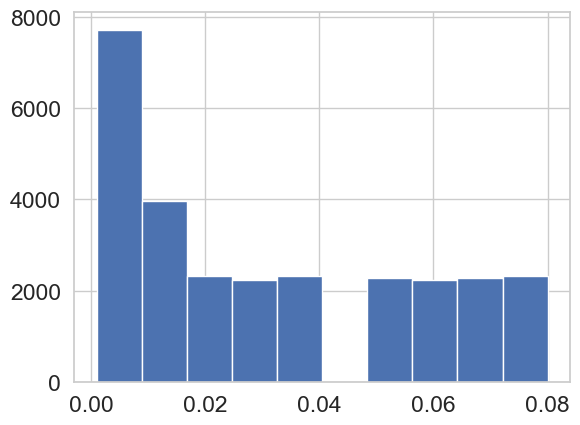

In [48]:
data_frame["S"].hist()

<AxesSubplot:xlabel='snap_time', ylabel='$\\widetilde{MO}_{t=0}$'>

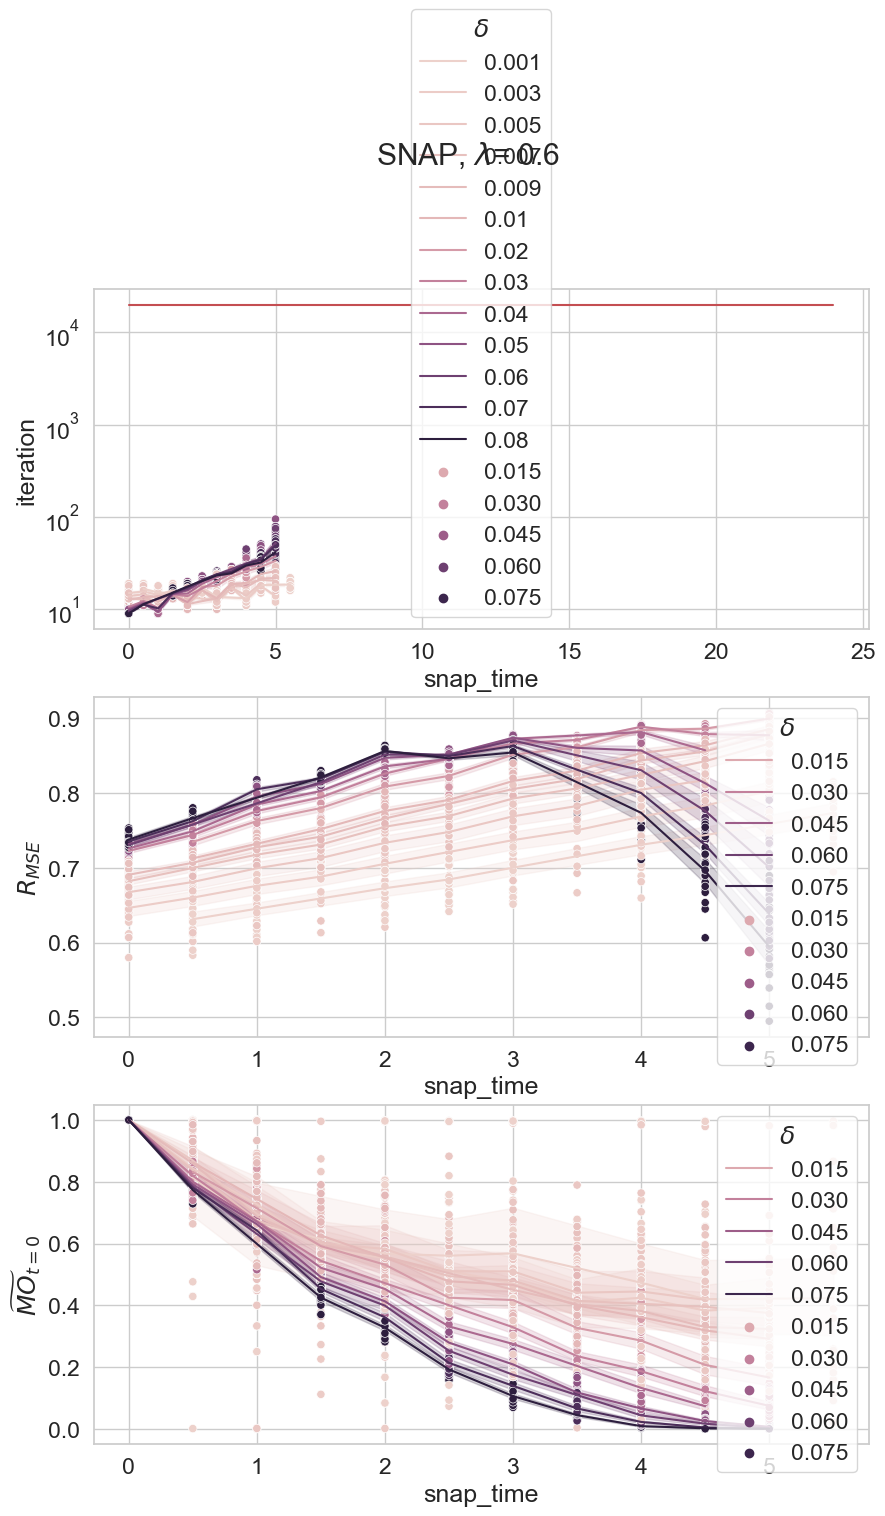

In [38]:
sns.set_theme(style="whitegrid", font_scale=1.5)
fig,axs = plt.subplots(3,1, figsize=(10,15))
plt.suptitle("SNAP, " + l_s + f"= 0.6")
init_s = "rnd"
log_it="iteration"
axs[0].set(yscale="log")
sns.lineplot(data=data_frame[(data_frame["init"]==init_s)], x=r"snap_time", hue=del_s, y=log_it,legend="full", ax=axs[0])
axs[0].plot([0,24], [20000,20000])
sns.scatterplot(data=data_frame[(data_frame["init"]==init_s)], x=r"snap_time", hue=del_s, y=log_it,legend=True, ax=axs[0])
sns.lineplot(data=data_frame[(data_frame["init"]==init_s)], x=r"snap_time", hue=del_s, y=r"$R_{MSE}$",legend=True, ax=axs[1])
sns.scatterplot(data=data_frame[(data_frame["init"]==init_s)], x=r"snap_time", hue=del_s, y=r"$R_{MSE}$",legend=True, ax=axs[1])
sns.lineplot(data=data_frame[(data_frame["init"]==init_s)], x=r"snap_time", hue=del_s, y=r"$\widetilde{MO}_{t=0}$",legend=True, ax=axs[2])
sns.scatterplot(data=data_frame[(data_frame["init"]==init_s)], x=r"snap_time", hue=del_s, y=r"$\widetilde{MO}_{t=0}$",legend=True, ax=axs[2])
#axs[0].set_yscale("log")

In [6]:
omo0_s = r"$\overline{MO}_{t=0}$"
oRmse_s = r"$\overline{R_{MSE}}$"
data_frame[omo0_s] = (data_frame[mo0t_s] - data_frame[r_s])/(1- data_frame[r_s])
data_frame[oRmse_s] = (data_frame[Rmse_s] - data_frame[r_s])/(1- data_frame[r_s])

### Heatmap

In [7]:
df = data_frame[((data_frame[i_s]==init) & (data_frame[g_s]==graph) & (data_frame[d_s]==d) & (data_frame[N_s]==N))]

In [30]:
y_s=omo0_s

In [31]:
l_list = np.sort(df[l_s].unique())
r_list = np.sort(df[r_s].unique())
del_list = np.sort(df[del_s].unique())

len_l = len(l_list)
len_r = len(r_list)
len_del = len(del_list)

y_tab = np.zeros((len_l,len_r,len_del))
l_tab = np.zeros((len_l,len_r,len_del))
r_tab = np.zeros((len_l,len_r,len_del))
d_tab = np.zeros((len_l,len_r,len_del))

for i_l,lam in enumerate(l_list):
    for i_r,rho in enumerate(r_list):
        for i_d,delta in enumerate(del_list):
            y_tab[i_l][i_r][i_d] = df[ (df[l_s]==lam) & (df[r_s]==rho) & (df[del_s]==delta)][y_s].mean()
            l_tab[i_l][i_r][i_d] = lam
            r_tab[i_l][i_r][i_d] = rho
            d_tab[i_l][i_r][i_d] = delta
df_flat = pd.DataFrame({r_s:r_tab.flatten(),l_s:l_tab.flatten(),del_s:d_tab.flatten(),y_s:y_tab.flatten()})
df_lam_list = []
for lam in l_list:
    df_lam_list.append( df_flat[ (df_flat[l_s]==lam)].drop(l_s,axis=1) )

In [32]:
df_lam_list[2].pivot(del_s,r_s,y_s)

$\rho$    0.00      0.05      0.10      0.15      0.20      0.25      0.30  \
$\delta$                                                                     
0.01       0.0  0.495431  0.876680  0.946278  0.960215  0.965863  0.967485   
0.02       0.0  0.202366  0.609386  0.827245  0.911918  0.941635  0.956865   
0.03       0.0  0.113248  0.408695  0.667690  0.809498  0.880820  0.916643   
0.04       0.0  0.062401  0.276813  0.510096  0.689087  0.802482  0.866818   
0.05       0.0  0.048143  0.205588  0.411209  0.590946  0.719510  0.808146   
0.06       0.0  0.035657  0.159607  0.334372  0.497721  0.636524  0.735385   
0.07       0.0  0.031840  0.131285  0.281478  0.432583  0.566327  0.671291   
0.08       0.0  0.021051  0.100167  0.223583  0.356977  0.489354  0.600659   
0.09       0.0  0.018230  0.088374  0.192980  0.316283  0.438437  0.553927   
0.10       0.0  0.017485  0.075421  0.170927  0.284313  0.396448  0.501153   

$\rho$        0.35  
$\delta$            
0.01      0.971897  
0.02      0.963915  
0.03      0.937973  
0.04      0.903919  
0.05      0.860529  
0.06      0.804999  
0.07      0.743184  
0.08      0.691264  
0.09      0.637564  
0.10      0.590116

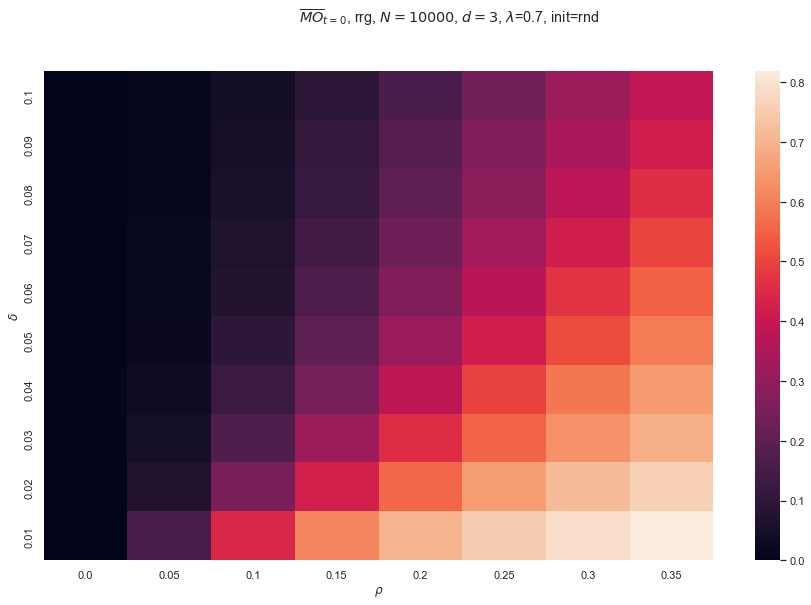

In [33]:
sns.set_theme(font_scale=1)
fig,ax = plt.subplots(figsize=(15,9))
rnd = np.random.choice(range(len(l_list)))
i=rnd
plt.suptitle(y_s + f", {graph}, $N={N}$, $d={d}$, " + l_s + f"={l_list[i]}, init={init}")
ax = sns.heatmap(df_lam_list[i].pivot(del_s,r_s,y_s))
ax.invert_yaxis()

#plt.tight_layout()
#fig.savefig(save_dir + f"NC_{graph}_N{N}_d{d}_LAM_RHO_ns5.pdf")

In [34]:
f_list = []
x_un_list = []
y_un_list = []
z_un_list = []
for i, df_lam in enumerate(df_lam_list):
    x = df_lam[r_s].values
    y = df_lam[del_s].values
    z = df_lam[y_s].values
    x_un_list.append(np.unique(x))
    y_un_list.append(np.unique(y))
    z_un_list.append(df_lam[y_s].values.reshape((len(np.unique(x)),-1)))
    f_list.append(scipy.interpolate.RectBivariateSpline(x_un_list[i], y_un_list[i], z_un_list[i]))

/var/folders/w6/zx_nxxqs3gdcq636sf5z6z2m0000gn/T/ipykernel_74925/3427715509.py:29: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(surf, cax=cbar_ax)


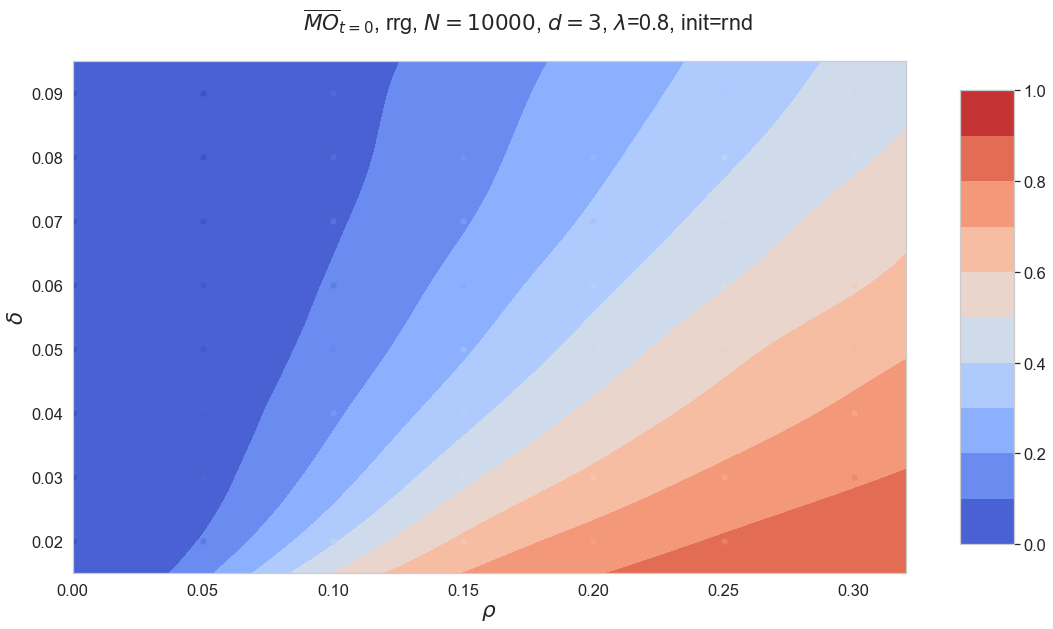

In [35]:
rnd = np.random.choice(range(len(l_list)))
i=rnd

sns.set_theme(style="whitegrid", font_scale=1.5)
fig,ax = plt.subplots(1,1, figsize=(15,9),)
plt.suptitle(y_s + f", {graph}, $N={N}$, $d={d}$, " + l_s + f"={l_list[i]}, init={init}")
levels=10
level_boundaries = np.linspace(0, 1, levels + 1)
# Make data.
X1 = np.arange(0, 0.35 + 0.001, 0.01)
Y1 = np.arange(0.01, 0.1 + 0.0001, 0.001)
X, Y = np.meshgrid(X1, Y1)
Z = np.array([ np.array([ max(min(f_list[i](x,y)[0][0],1),0) for x in X1]) for y in Y1])
# Plot the surface.
surf = ax.contourf(X, Y, Z, cmap=cm.coolwarm, levels=level_boundaries)

for i_x, x in enumerate(x_un_list[i]):
    for i_y, y in enumerate(y_un_list[i]):
        ax.scatter(x, y, s=40, color=cm.coolwarm(z_un_list[i][i_x][i_y]), edgecolors='grey', linewidths=0.)
        pass
ax.set_xlabel(r_s, fontsize='large')
ax.set_ylabel(del_s,  fontsize='large')
ax.set_xlim([0,0.32])
ax.set_ylim([0.015,0.095])
# Add a color bar which maps values to colors.
plt.tight_layout()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
fig.colorbar(surf, cax=cbar_ax)

#fig.savefig(f"PhaseDiagRMSE_{graph}_N{N}_d{d}_RHO_DEL_lam.pdf")

/var/folders/w6/zx_nxxqs3gdcq636sf5z6z2m0000gn/T/ipykernel_74925/3634571011.py:29: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(surf, cax=cbar_ax)


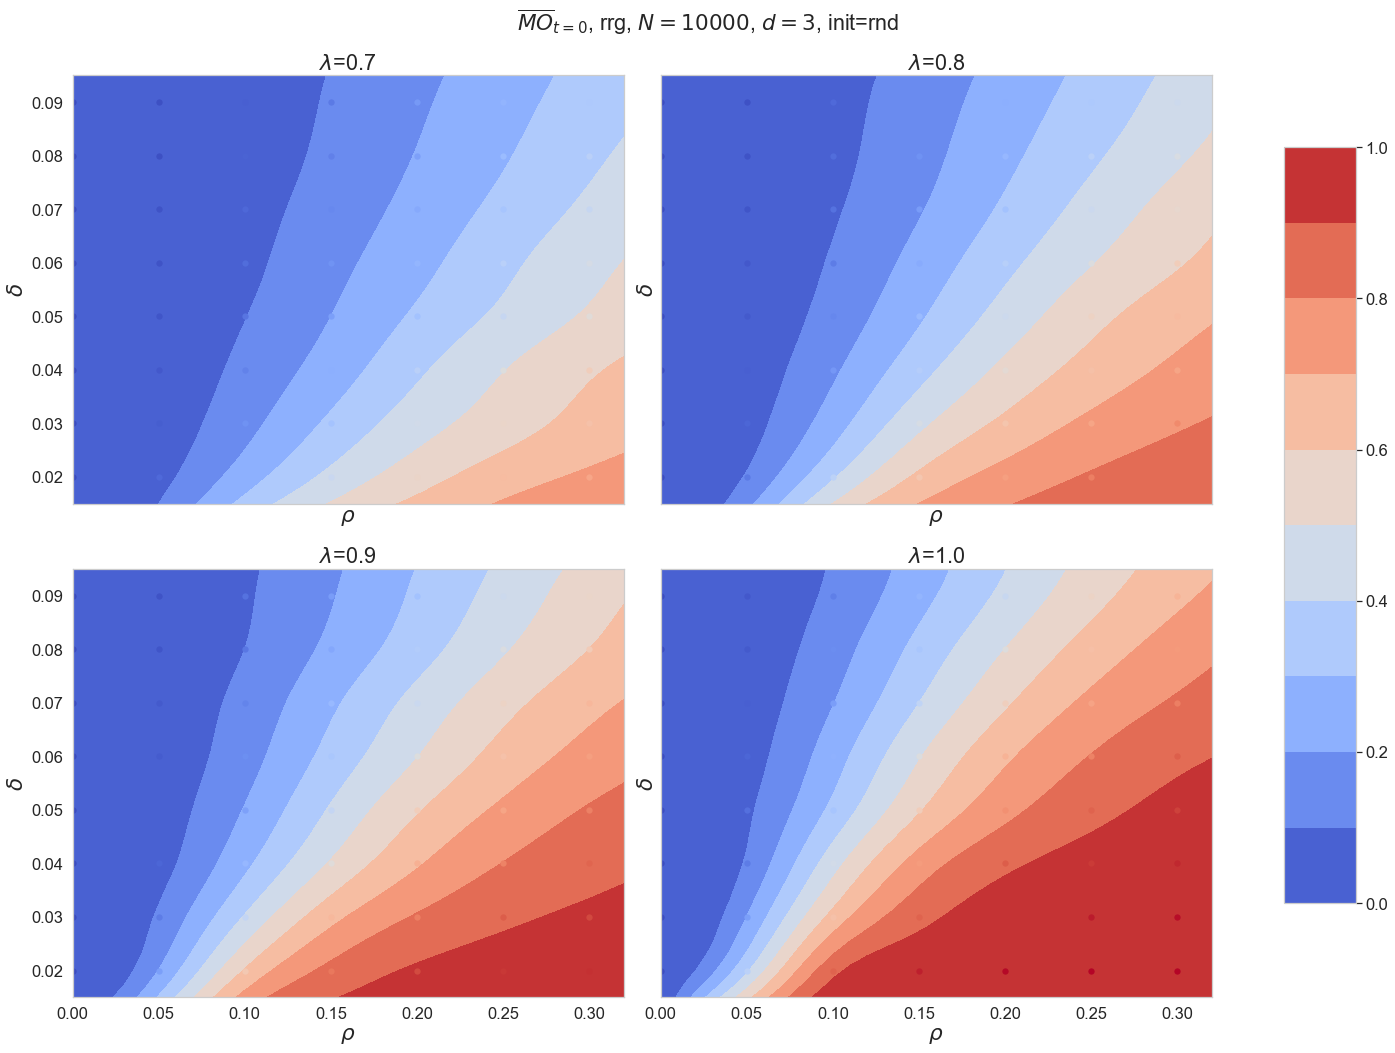

In [36]:
fig, axs = plt.subplots(2,2, figsize=(20,15), sharex=True, sharey=True)
plt.suptitle(y_s + f", {graph}, $N={N}$, $d={d}$, " + f"init={init}")
levels=10
level_boundaries = np.linspace(0, 1, levels + 1)
for i in range(len(l_list)):
    # Make data.
    X1 = np.arange(0, 0.35 + 0.001, 0.01)
    Y1 = np.arange(0.01, 0.1 + 0.0001, 0.001)
    X, Y = np.meshgrid(X1, Y1)
    Z = np.array([ np.array([ max(min(f_list[i](x,y)[0][0],1),0) for x in X1]) for y in Y1])
    # Plot the surface.

    surf = axs[int(i/2)][i%2].contourf(X, Y, Z, cmap=cm.coolwarm, levels=level_boundaries)
    
    for i_x, x in enumerate(x_un_list[i]):
        for i_y, y in enumerate(y_un_list[i]):
            axs[int(i/2)][i%2].scatter(x,y, s=40, color=cm.coolwarm(z_un_list[i][i_x][i_y]), edgecolors='grey', linewidths=0.)

    axs[int(i/2)][i%2].set_xlabel(r_s, fontsize='large')
    axs[int(i/2)][i%2].set_ylabel(del_s,  fontsize='large')
    axs[int(i/2)][i%2].set_title(l_s + f"={l_list[i]}",  fontsize='large')
    axs[int(i/2)][i%2].set_xlim([0,0.32])
    axs[int(i/2)][i%2].set_ylim([0.015,0.095])

# Add a color bar which maps values to colors.
plt.tight_layout()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
fig.colorbar(surf, cax=cbar_ax)

#fig.savefig(f"PhaseDiagRMSE_{graph}_N{N}_d{d}_RHO_DEL_lam.pdf")